In [203]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
import pandas as pd
import matplotlib 
from astropy.table import Table
import scipy.signal as sp

In [204]:
# define a funtion to return 0 when divided by zero
def div0(a, b, fill=0.):
    """ a / b, divide by 0 -> `fill`
        div0( [-1, 0, 1], 0, fill=np.nan) -> [nan nan nan]
        div0( 1, 0, fill=np.inf ) -> inf
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
    if np.isscalar(c):
        return c if np.isfinite( c ) \
            else fill
    else:
        c[~np.isfinite(c)] = fill
        return c


def resampling(target_array, ref_array, input_array, resamp_ref_array=False):

    # for each value in the target_array, find the indeices of the value(s)
    # nearest to it in the ref_array, output has the same legth as the target_array
    index = abs(target_array[:, None] - ref_array[None, :]).argmin(axis=-1)

    # based on the indices find the corresponding values in the input_array and
    # write everything into a new array
    resampled_array = []
    for i in index:
        resampled_array.append(input_array[i])

    # choose if to output the resampled ref_array, sometimes you need this
    if resamp_ref_array == True:
        resampled_ref_array = []
        for i in index:
            resampled_ref_array.append(ref_array[i])
        return resampled_array, resampled_ref_array
    else:
        return resampled_array


def prospector_flux_unit_conversion(wavelength, flux):
    'convert prospector from maggie to (10^-19 ergs s^-1 cm^-2 Angstrom^-1)'
    return (flux * 3.631e6 * 1e-26 * 3e18) / (np.square(wavelength))


def plot_NIRES(name,
               scale,
               x_left=6300,
               x_right=6800,
               vlines=True,
               show_fitting_area=True,
              label_NIRES=False):

    data = fits.open('NIRES_reduced_spec/' + name + '_coadd.fits')[1].data
    wave = data['WAVE']
    flux = data['FLUX'] * scale
    ivar = data['IVAR']

    z = target_props.loc[name, 'z_spec']

    zcorr_wave = np.divide(wave, (1 + z))

    sliced_wave_inds = np.where((x_left <= zcorr_wave)
                                & (zcorr_wave <= x_right))[0]
    sliced_flux = flux[sliced_wave_inds[0]:sliced_wave_inds[-1]]
    sliced_wave = zcorr_wave[sliced_wave_inds[0]:sliced_wave_inds[-1]]
    sliced_ivar = ivar[sliced_wave_inds[0]:sliced_wave_inds[-1]]
    meidan_flux = np.median(sliced_flux)

    flux_smoothed = sp.medfilt(sliced_flux,kernel_size=5)

    plt.plot(sliced_wave,
             scale / np.sqrt(sliced_ivar),
             c='pink',
             label='Noise')
    plt.plot(sliced_wave, sliced_flux, c='grey', alpha=0.3, label='spec')
    plt.plot(sliced_wave,
             flux_smoothed,
             c='black',
             alpha=0.8,linewidth=0.9,
             label='spec smoothed')

    if vlines:
        plt.vlines(6564.6, ymax=1200, ymin=0, colors='red', linewidth=1.5)
        plt.vlines(6585.27, ymax=1200, ymin=0, colors='purple', linewidth=1.5)
        plt.vlines(6549.86, ymax=1200, ymin=0, colors='purple', linewidth=1.5)
        plt.text(6566,
                 meidan_flux * 1.6,
                 '6564.6 H alpha',
                 rotation='vertical',
                 fontsize=13)
        plt.text(6586,
                 meidan_flux * 1.6,
                 '6585.27 NII',
                 rotation='vertical',
                 fontsize=13)
        plt.text(6552,
                 meidan_flux * 1.6,
                 '6549.86 NII',
                 rotation='vertical',
                 fontsize=13)
    else:
        pass
    
    if label_NIRES:
        plt.text(6050, meidan_flux * 1.8, 'NIRES Spectrum', rotation='horizontal', fontsize=20,weight='bold')
    else:pass
    
    if show_fitting_area:
        if name == 'J1448+1010':
            left_fill = 6520
            right_fill = 6620
        else:
            left_fill = 6530
            right_fill = 6600
        plt.fill_between(np.linspace(6410, left_fill),
                         0.8 * meidan_flux,
                         1.2 * meidan_flux,
                         facecolor='red',
                         alpha=0.2,
                         label='model fitting area')

        plt.fill_between(np.linspace(right_fill, 6700),
                         0.8 * meidan_flux,
                         1.2 * meidan_flux,
                         facecolor='red',
                         alpha=0.2)
    else:
        pass

    if name == 'J1448+1010':
        plt.ylim(0, 2.5 * meidan_flux)
    else:
        plt.ylim(0, 2.2 * meidan_flux)
    plt.title(f'{name} Spec, z={z}', fontsize=18)
    plt.xlabel(r'Wavelength [$\mathring{A}$]', fontsize=18)
    plt.ylabel(r'$Flux_\lambda$ [$erg/s/cm^2/\mathring{A}$]', fontsize=18)
    plt.legend()

In [205]:
#### IGNORE THIS FOR NOW

def NIRES_2_prospector_scaling(name, left_wave_lim=6410, right_wave_lim=6700):
    # import target proporties
    target_props = pd.read_csv('NIRES_target_properties.csv', index_col=0)
    # import alma best fit models
    model = pd.read_csv('best_fit_models_alma/outputs/spec-' +
                        target_props.loc[name, 'plate-MJD-fiber'] + '.txt',
                        sep=' ',
                        header=None,
                        skiprows=1,
                        names=['wavelength', 'spec_neb', 'spec_noneb'])

    # uinit conversion from prospector model flux unit(maggies) to SDSS flux unit, but slightly off by a factor
    model['spec_neb'] = prospector_flux_unit_conversion(model['wavelength'],model['spec_neb'])
    model['spec_noneb'] = prospector_flux_unit_conversion(model['wavelength'],model['spec_noneb'])

    model_sliced_SDSS = model.iloc[model[
        model.wavelength >= 4250].index[0]:model[
            model.wavelength <= 4870].index[-1]]

    # import the data and redshift
    data = fits.open('NIRES_reduced_spec/' + name + '_coadd.fits')[1].data
    z = target_props.loc[name, 'z_spec']
    sci_wave = np.divide(data['WAVE'], (1 + z))
    sci_flux = data['FLUX']
    
    # import SDSS data
    SDSS_spec_hdul = fits.open('SDSS_PSB_Catalog/spectra/spec-' +
                               target_props.loc[name, 'plate-MJD-fiber'] +
                               '.fits')
    SDSS_wave = (10**SDSS_spec_hdul[1].data['loglam']) / (1 + z)
    SDSS_flux = SDSS_spec_hdul[1].data['flux'] * 1e-17
    # slice the SDSS data
    SDSS_lo = np.abs(SDSS_wave - 3500).argmin()
    SDSS_up = np.abs(SDSS_wave - 6000).argmin()
    SDSS_wave_sliced = SDSS_wave[SDSS_lo:SDSS_up]
    SDSS_flux_sliced = SDSS_flux[SDSS_lo:SDSS_up]
    # resample SDSS data to model
    SDSS_flux_sliced = resampling(np.array(model_sliced_SDSS.wavelength),
                                  np.array(SDSS_wave_sliced),
                                  np.array(SDSS_flux_sliced))

    # find a rough scale by divide the median of the model and SDSS data
    SDSS_rough_scale =  np.median(
        model_sliced_SDSS['spec_noneb'])/np.median(SDSS_flux_sliced)

    '''# define 500 candidates +- 30% of the rough scale
    SDSS_candidate_scales = np.linspace(
        SDSS_rough_scale - 0.5 * SDSS_rough_scale,
        SDSS_rough_scale + 0.5 * SDSS_rough_scale, 1000)

    # caculate the sum of the square of residuals in those two regions combined
    SDSS_residual_square_sum = []
    for s in SDSS_candidate_scales:
        SDSS_residual_square_sum.append(
            sum(
                np.square(
                    np.multiply(s, model_sliced_SDSS['spec_noneb']) -
                    SDSS_flux_sliced)))

    # find the smallest residual square sum and corresponding scale
    prospector_scaling_factor = SDSS_candidate_scales[np.argmin(
        SDSS_residual_square_sum)]'''
    SDSS_scaling_factor =  SDSS_rough_scale
    #################################################################################################

    # slice the model
    model_sliced = model.iloc[model[
        model.wavelength >= left_wave_lim].index[0]:model[
            model.wavelength <= right_wave_lim].index[-1]]

    # slice the data
    sci_lo = np.abs(sci_wave - left_wave_lim).argmin()
    sci_up = np.abs(sci_wave - right_wave_lim).argmin()
    sci_wave_sliced = sci_wave[sci_lo:sci_up]
    sci_flux_sliced = sci_flux[sci_lo:sci_up]

    # define a median and replace some outliers resulted from stitching orders
    median_sci_flux = np.median(sci_flux_sliced)
    # replace outliers defined as larger or smaller than 100 times the flux median
    outlier_ind = list(
        np.where(sci_flux_sliced >= 50 * median_sci_flux)[0]) + list(
            np.where(sci_flux_sliced <= 50 * median_sci_flux)[0])

    for i in outlier_ind:
        sci_flux_sliced[i] = median_sci_flux

    # make sci dataframe. though proved to be less useful
    # since panda and fits files has some funny compatability issues
    sci_df = pd.DataFrame({
        'wavelength': sci_wave_sliced,
        'flux': sci_flux_sliced
    })

    # least square scaling of data
    # define two ranges to be used as fitting regions (avoid the Ha)
    if name == 'J1448+1010':
        range1 = [left_wave_lim, 6520]
        range2 = [6620, right_wave_lim]
    else:
        range1 = [left_wave_lim, 6530]
        range2 = [6600, right_wave_lim]
    # find a rough scale by divide the median of the model and data
    rough_scale = np.median(model_sliced['spec_noneb']) / np.median(sci_df.flux)
    # define 500 candidates +- 30% of the rough scale
    candidate_scales = np.linspace(rough_scale - 0.3 * rough_scale,
                                   rough_scale + 0.3 * rough_scale, 1000)

    # resample the model to the shape of science data
    spec_neb = resampling(np.array(sci_df.wavelength),
                          np.array(model.wavelength), np.array(model.spec_neb))
    spec_noneb = resampling(np.array(sci_df.wavelength),
                            np.array(model.wavelength),
                            np.array(model.spec_noneb))
    model_resamp = pd.DataFrame({
        'wavelength': sci_wave_sliced,
        'spec_neb': spec_neb,
        'spec_noneb': spec_noneb
    })

    # define two regions around Ha absorbation region to fit
    model_left = model_resamp.iloc[0:model_resamp[
        model_resamp.wavelength <= range1[1]].index[-1]]
    model_right = model_resamp.iloc[model_resamp[
        model_resamp.wavelength >= range2[0]].index[0]:-1]

    sci_left_ind = model_resamp[model_resamp.wavelength <= range1[1]].index[-1]
    sci_right_ind = model_resamp[model_resamp.wavelength >= range2[0]].index[0]

    sci_flux_left = sci_flux_sliced[0:sci_left_ind]
    sci_flux_right = sci_flux_sliced[sci_right_ind:-1]

    # caculate the sum of the square of residuals in those two regions combined
    residual_square_sum = []
    for s in candidate_scales:
        residual_square_sum.append(
            sum(
                list(np.square(s * sci_flux_left - model_left['spec_noneb'])) +
                list(np.square(s * sci_flux_right - model_right['spec_noneb']))))
    # find the smallest residual square sum and corresponding scale
    scaling_factor = candidate_scales[np.argmin(residual_square_sum)]

    return scaling_factor, model, SDSS_scaling_factor

In [206]:
def NIRES_2_FAST_scaling(name, left_wave_lim=6410, right_wave_lim=6700):

    # import target proporties
    target_props = pd.read_csv('NIRES_target_properties.csv', index_col=0)
    z = target_props.loc[name, 'z_spec']
    # import FAST best fit models, FAST have the unit erg/s/cm^2/Angstrom
    plate_MJD_fiber = target_props.loc[name, 'plate-MJD-fiber']
    plateMJDfiber = plate_MJD_fiber[0:4] + plate_MJD_fiber[
        5:10] + plate_MJD_fiber[11:15]
    
    model = np.genfromtxt('SDSS_PSB_Catalog/best_fits/' + plateMJDfiber + '_' +
                          plateMJDfiber + '.fit')
    # note that the FAST model are not in rest frame, so apply redshift correction
    model = pd.DataFrame({
        'wavelength': model[:, 0] / (1 + z),
        'flux': model[:, 1] * (1 + z)
    })
    # the FAST models are in air wavelength, so also need to convert to vacuum
    s_list = np.divide(10**4, model.wavelength)
    n_list = []
    for s in s_list:
        n_list.append(1 + 0.00012336624212083 + 0.02408926869968 /
                      (130.1065924522 - s**2) + 0.0001599740894897 /
                      (38.92568793293 - s**2))
    model.wavelength = np.multiply(model.wavelength, n_list)
    
    model_sliced_SDSS = model.iloc[model[
    model.wavelength >= 4250].index[0]:model[
        model.wavelength <= 4870].index[-1]]
    
    # import SDSS data
    SDSS_spec_hdul = fits.open('SDSS_PSB_Catalog/spectra/spec-' +
                               target_props.loc[name, 'plate-MJD-fiber'] +
                               '.fits')
    SDSS_wave = (10**SDSS_spec_hdul[1].data['loglam']) / (1 + z)
    SDSS_flux = SDSS_spec_hdul[1].data['flux'] * 1e-17
    # slice the SDSS data
    SDSS_lo = np.abs(SDSS_wave - 3500).argmin()
    SDSS_up = np.abs(SDSS_wave - 6000).argmin()
    SDSS_wave_sliced = SDSS_wave[SDSS_lo:SDSS_up]
    SDSS_flux_sliced = SDSS_flux[SDSS_lo:SDSS_up]
    # resample SDSS data to model
    SDSS_flux_sliced = resampling(np.array(model_sliced_SDSS.wavelength),
                                  np.array(SDSS_wave_sliced),
                                  np.array(SDSS_flux_sliced))

    # find a rough scale by divide the median of the model and SDSS data
    SDSS_rough_scale =  np.median(
        model_sliced_SDSS['flux'])/np.median(SDSS_flux_sliced)
    SDSS_2_FAST_scaling_factor = SDSS_rough_scale
    ###################################################################################
    # slice the model
    model_sliced = model.iloc[model[
        model.wavelength >= left_wave_lim].index[0]:model[
            model.wavelength <= right_wave_lim].index[-1]]

    # import the data and redshift
    data = fits.open('NIRES_reduced_spec/' + name + '_coadd.fits')[1].data
    sci_wave = np.divide(data['WAVE'], (1 + z))
    sci_flux = data['FLUX']

    # slice the data
    sci_lo = np.abs(sci_wave - left_wave_lim).argmin()
    sci_up = np.abs(sci_wave - right_wave_lim).argmin()
    sci_wave_sliced = sci_wave[sci_lo:sci_up]
    sci_flux_sliced = sci_flux[sci_lo:sci_up]

    # define a median and replace some outliers resulted from stitching orders
    median_sci_flux = np.median(sci_flux_sliced)
    # replace outliers defined as larger or smaller than 100 times the flux median
    outlier_ind = list(
        np.where(sci_flux_sliced >= 50 * median_sci_flux)[0]) + list(
            np.where(sci_flux_sliced <= 50 * median_sci_flux)[0])

    for i in outlier_ind:
        sci_flux_sliced[i] = median_sci_flux

    # make sci dataframe. though proved to be less useful
    # since panda and fits files has some funny compatability issues
    sci_df = pd.DataFrame({
        'wavelength': sci_wave_sliced,
        'flux': sci_flux_sliced
    })

    # least square scaling of data
    # define two ranges to be used as fitting regions (avoid the Ha)
    if name == 'J1448+1010':
        range1 = [left_wave_lim, 6520]
        range2 = [6620, right_wave_lim]
    else:
        range1 = [left_wave_lim, 6530]
        range2 = [6600, right_wave_lim]
    # find a rough scale by divide the median of the model and data
    rough_scale = np.median(model_sliced['flux']) / np.median(sci_df.flux)
    # define 500 candidates +- 30% of the rough scale
    candidate_scales = np.linspace(rough_scale - 0.5 * rough_scale,
                                   rough_scale + 0.5 * rough_scale, 1000)

    # resample the model to the shape of science data
    model_flux = resampling(np.array(sci_df.wavelength),
                            np.array(model.wavelength), np.array(model.flux))
    model_resamp = pd.DataFrame({
        'wavelength': sci_wave_sliced,
        'flux': model_flux,
    })

    # define two regions around Ha absorbation region to fit
    model_left = model_resamp.iloc[0:model_resamp[
        model_resamp.wavelength <= range1[1]].index[-1]]
    model_right = model_resamp.iloc[model_resamp[
        model_resamp.wavelength >= range2[0]].index[0]:-1]

    sci_left_ind = model_resamp[model_resamp.wavelength <= range1[1]].index[-1]
    sci_right_ind = model_resamp[model_resamp.wavelength >= range2[0]].index[0]

    sci_flux_left = sci_flux_sliced[0:sci_left_ind]
    sci_flux_right = sci_flux_sliced[sci_right_ind:-1]

    # caculate the sum of the square of residuals in those two regions combined
    residual_square_sum = []
    for s in candidate_scales:
        residual_square_sum.append(
            sum(
                list(np.square(s * sci_flux_left - model_left['flux'])) +
                list(np.square(s * sci_flux_right - model_right['flux']))))
    # find the smallest residual square sum and corresponding scale
    scaling_factor = candidate_scales[np.argmin(residual_square_sum)]

    return scaling_factor, model, SDSS_2_FAST_scaling_factor

In [212]:
target_props = pd.read_csv('NIRES_target_properties.csv', index_col=0)
target_names = list(target_props.index)
plate_MJD_fiber = list(target_props['plate-MJD-fiber'])
z_spec = list(target_props['z_spec'])

NIRES_scaling_factors = []
SDSS_scaling_factors = []

for name in target_names:
    if name == 'blobJ1448+1010': pass
    else:
        NIRES_2_FAST_scaling_factor, FAST_model, SDSS_2_FAST_scaling_factor = NIRES_2_FAST_scaling(
        name)
        NIRES_scaling_factors.append(NIRES_2_FAST_scaling_factor)
        SDSS_scaling_factors.append(SDSS_2_FAST_scaling_factor)
        
# save the scaling factors
scaling_factors = pd.DataFrame(
    {
        'plate-MJD-fiber': plate_MJD_fiber[1:],
        'z_spec': z_spec[1:],
        'NIRES_2_FAST_scaling_factor': NIRES_scaling_factors,
        'SDSS_2_FAST_scaling_factor': SDSS_scaling_factors,
    },
    index=target_names[1:])
scaling_factors.to_csv('scaling_factors.csv')

In [215]:
def plot_spectra_with_models(name, plot_SDSS=False):
    z = target_props.loc[name, 'z_spec']
    print('plate-MJD-fiber:', target_props.loc[name, 'plate-MJD-fiber'])

    NIRES_2_prospector_scaling_factor, prospector_model, SDSS_2_prospector_scaling_factor = NIRES_2_prospector_scaling(
        name)
    NIRES_2_FAST_scaling_factor, FAST_model, SDSS_2_FAST_scaling_factor = NIRES_2_FAST_scaling(
        name)

    if plot_SDSS:
        # read the SDSS data
        SDSS_spec_hdul = fits.open('SDSS_PSB_Catalog/spectra/spec-' +
                                   target_props.loc[name, 'plate-MJD-fiber'] +
                                   '.fits')
        SDSS_wave = (10**SDSS_spec_hdul[1].data['loglam']) / (1 + z)
        SDSS_flux = SDSS_spec_hdul[1].data['flux'] * 1e-17
        SDSS_ivar = SDSS_spec_hdul[1].data['ivar'] / np.square(1e-17)
        SDSS_lo = np.abs(SDSS_wave - 3500).argmin()
        SDSS_up = np.abs(SDSS_wave - 6000).argmin()
        SDSS_wave = SDSS_wave[SDSS_lo:SDSS_up]
        SDSS_flux = SDSS_flux[SDSS_lo:SDSS_up] * SDSS_2_FAST_scaling_factor
        SDSS_ivar = SDSS_ivar[SDSS_lo:SDSS_up]
        SDSS_mdeian_flux = np.median(SDSS_flux)

        #plot SDSS
        plt.figure(figsize=[35, 10])
        plt.xlim(3500, 6800)
        plot_NIRES(name,
                   NIRES_2_FAST_scaling_factor,
                   x_left=6000,
                   x_right=6800,
                   label_NIRES=True)
        plt.plot(SDSS_wave, SDSS_flux, c='gray', alpha=0.3)
        plt.plot(SDSS_wave,
                 sp.medfilt(SDSS_flux, kernel_size=5),
                 c='black',
                 alpha=0.8,
                 linewidth=0.9)
        plt.plot(SDSS_wave, div0(1, np.sqrt(SDSS_ivar)), c='pink')

        plt.text(4864,
                 1.2 * SDSS_mdeian_flux,
                 '4861 H beta',
                 rotation='vertical',
                 fontsize=13)
        plt.text(4000,
                 0.45 * SDSS_mdeian_flux,
                 'SDSS Spectrum',
                 rotation='horizontal',
                 fontsize=20,
                 weight='bold')
        plt.vlines(4861.33, ymax=0.1, ymin=0, colors='green', linewidth=1.5)
        plt.vlines(6000, ymax=0.1, ymin=0, colors='red', linewidth=3)

        #plot model

        plt.plot(FAST_model['wavelength'],
                 FAST_model['flux'],
                 label='FAST model',
                 c='green',
                 linewidth=1.5,
                 alpha=0.6)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.legend()
        plt.savefig(f'NIRES+SDSS_spec_image/{name}NIRES+SDSS_Spec.png')

    else:
        plt.figure(figsize=[14, 8])
        plt.xlim(6300, 6800)
        plot_NIRES(name,
                   NIRES_2_FAST_scaling_factor,
                   x_left=6300,
                   x_right=6800)
        #plot model
        plt.plot(
            FAST_model['wavelength'],
            FAST_model['flux'],
            label='FAST model',
            c='green',
            linewidth=1,
            alpha=0.8)
        plt.legend()
        plt.savefig(f'NIRES_reduced_spec_images/fittings/{name} Spec-fit.png')

plate-MJD-fiber: 0705-52200-0614


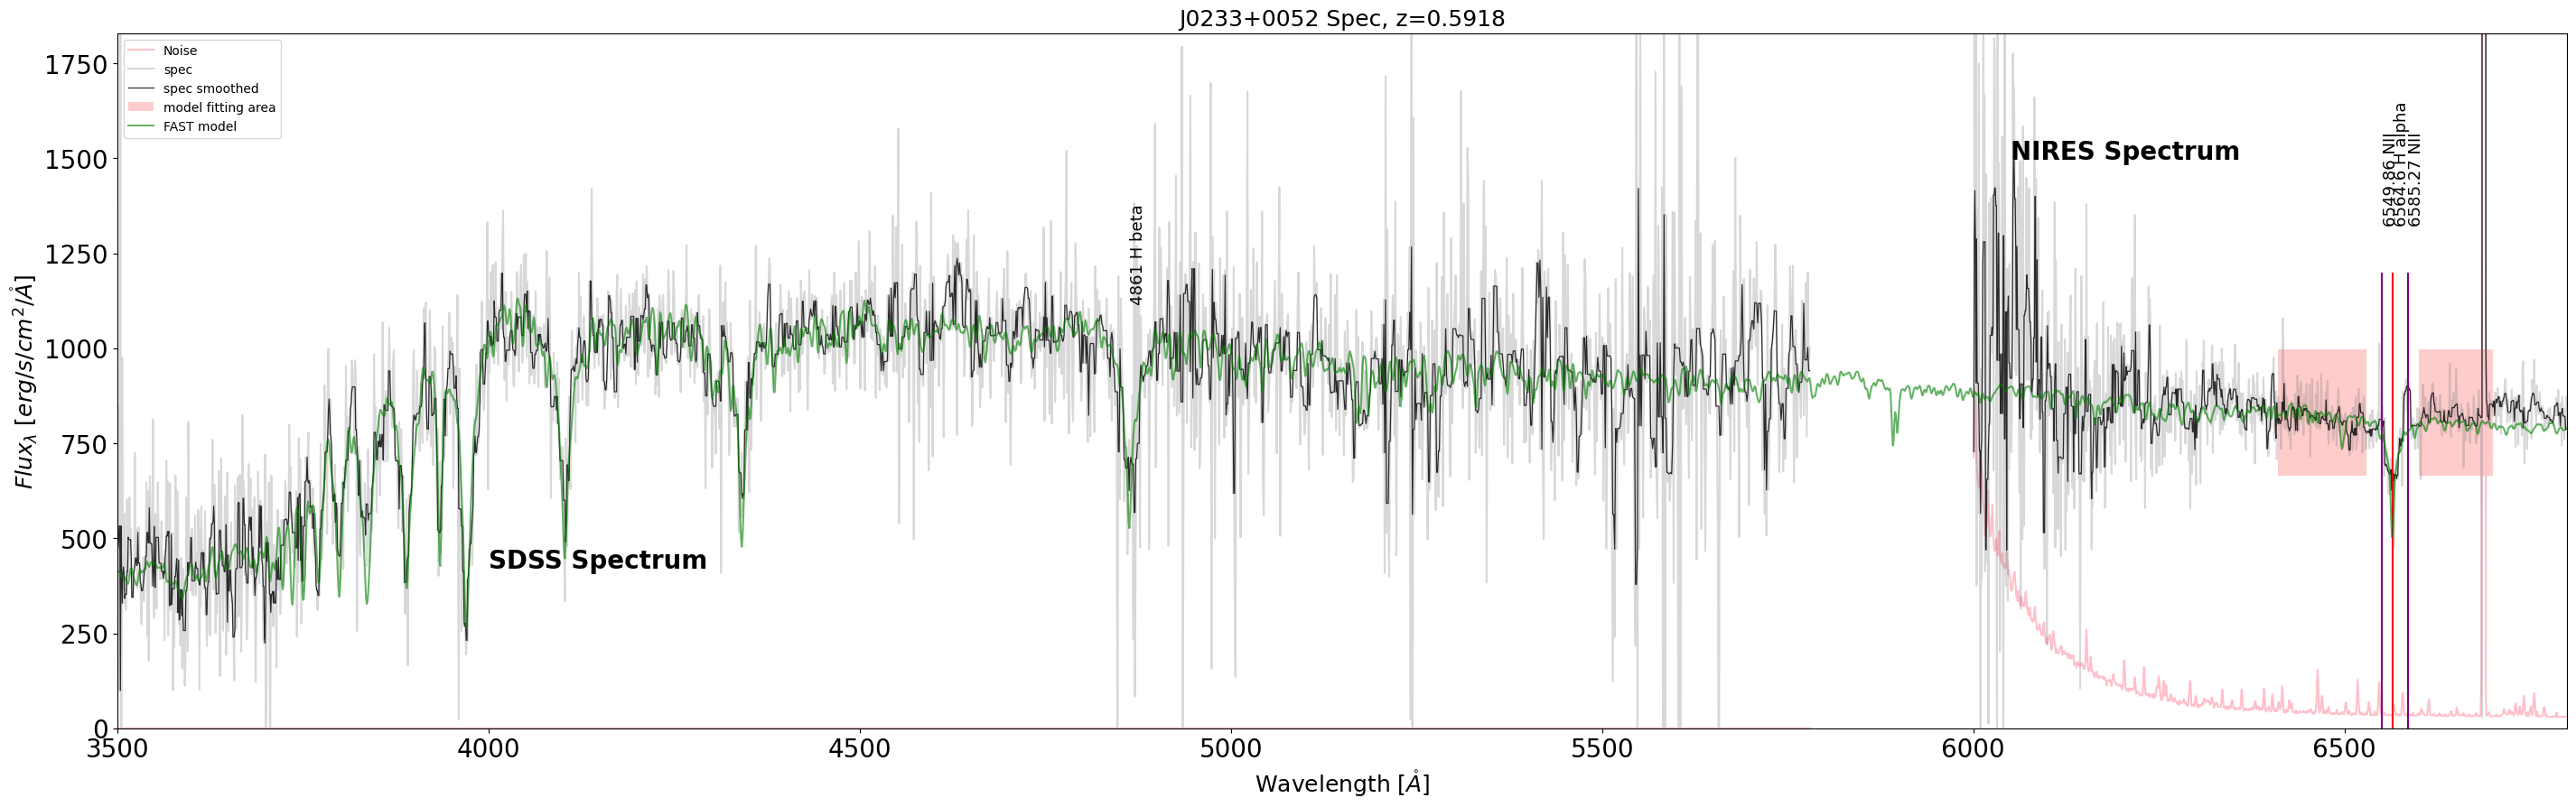

In [216]:
plot_spectra_with_models('J0233+0052',plot_SDSS=True)

plate-MJD-fiber: 5475-56011-0379
plate-MJD-fiber: 4466-55857-0198
plate-MJD-fiber: 6417-56308-0055
plate-MJD-fiber: 4302-55531-0482
plate-MJD-fiber: 1105-52937-0311
plate-MJD-fiber: 6308-56215-0977
plate-MJD-fiber: 0705-52200-0614
plate-MJD-fiber: 4370-55534-0762
plate-MJD-fiber: 0278-51900-0193
plate-MJD-fiber: 2595-54207-0459
plate-MJD-fiber: 6458-56274-0501
plate-MJD-fiber: 2438-54056-0396
plate-MJD-fiber: 5421-55980-0512


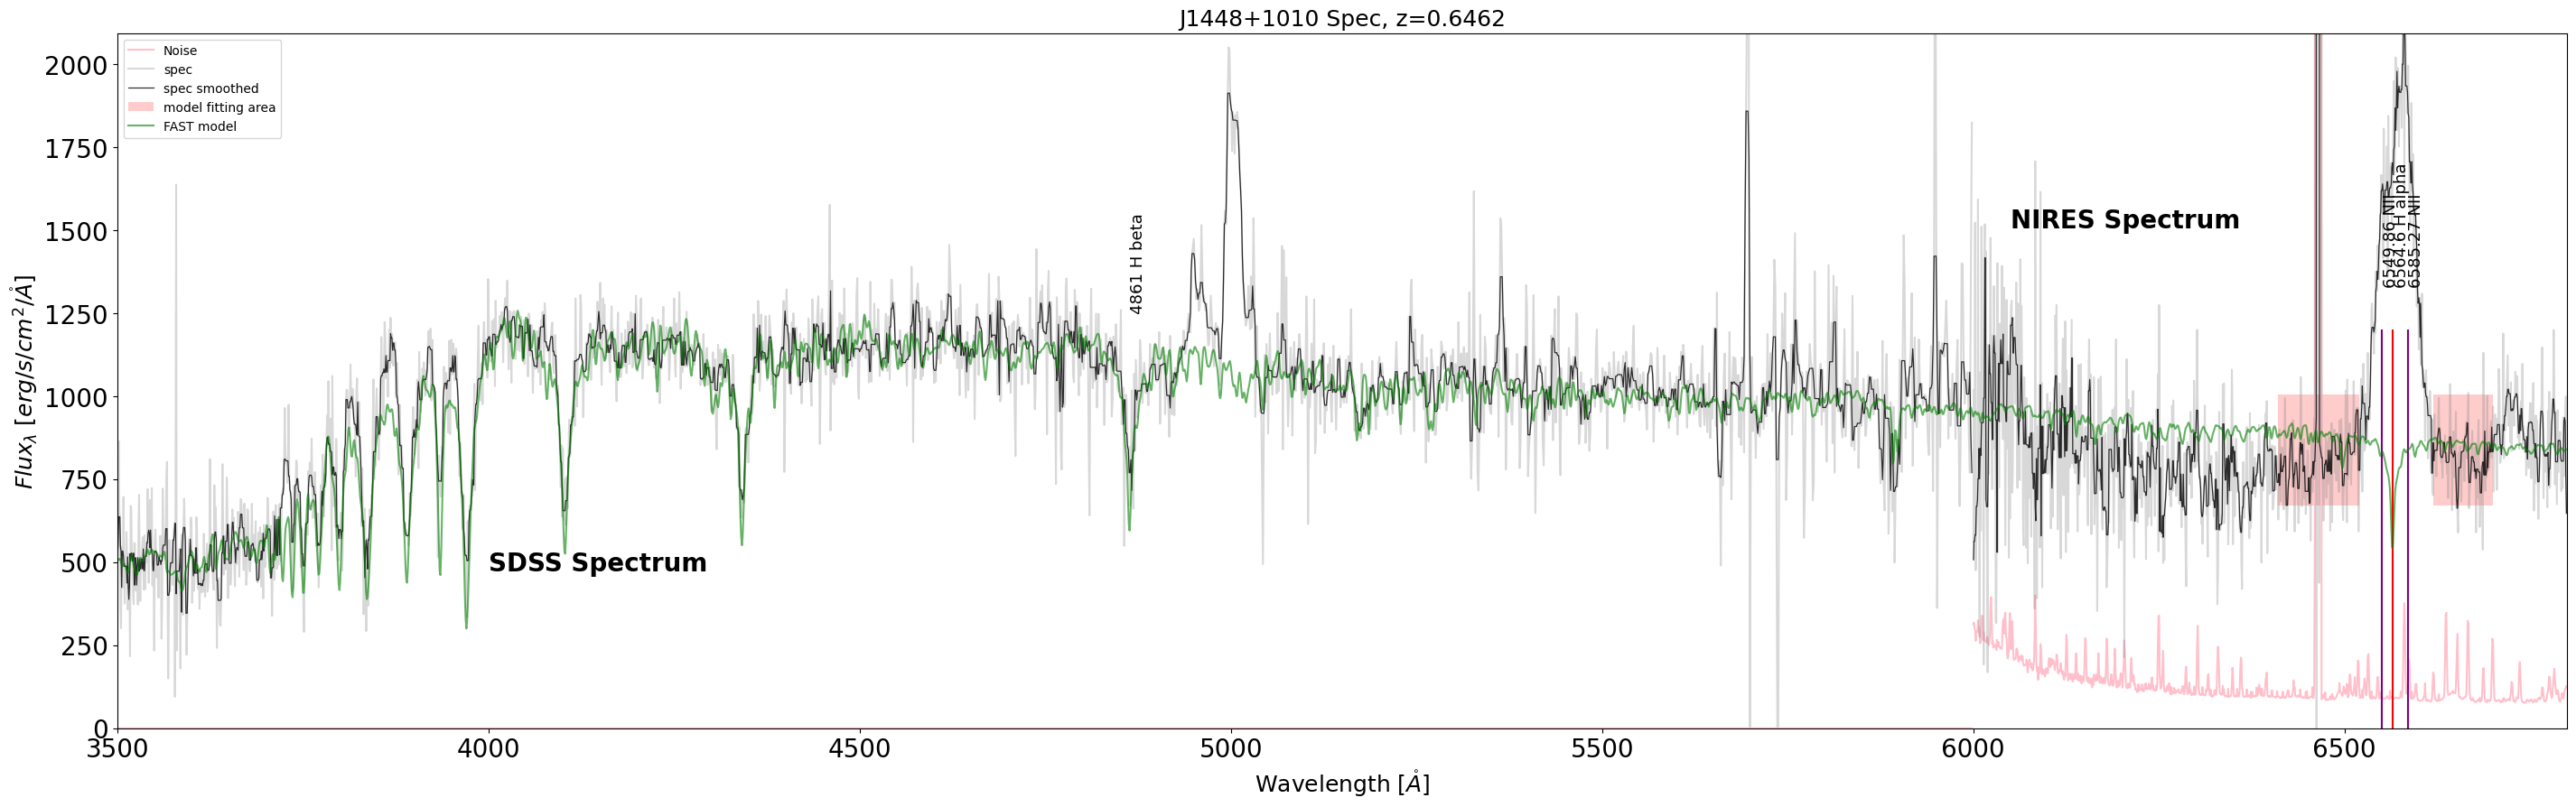

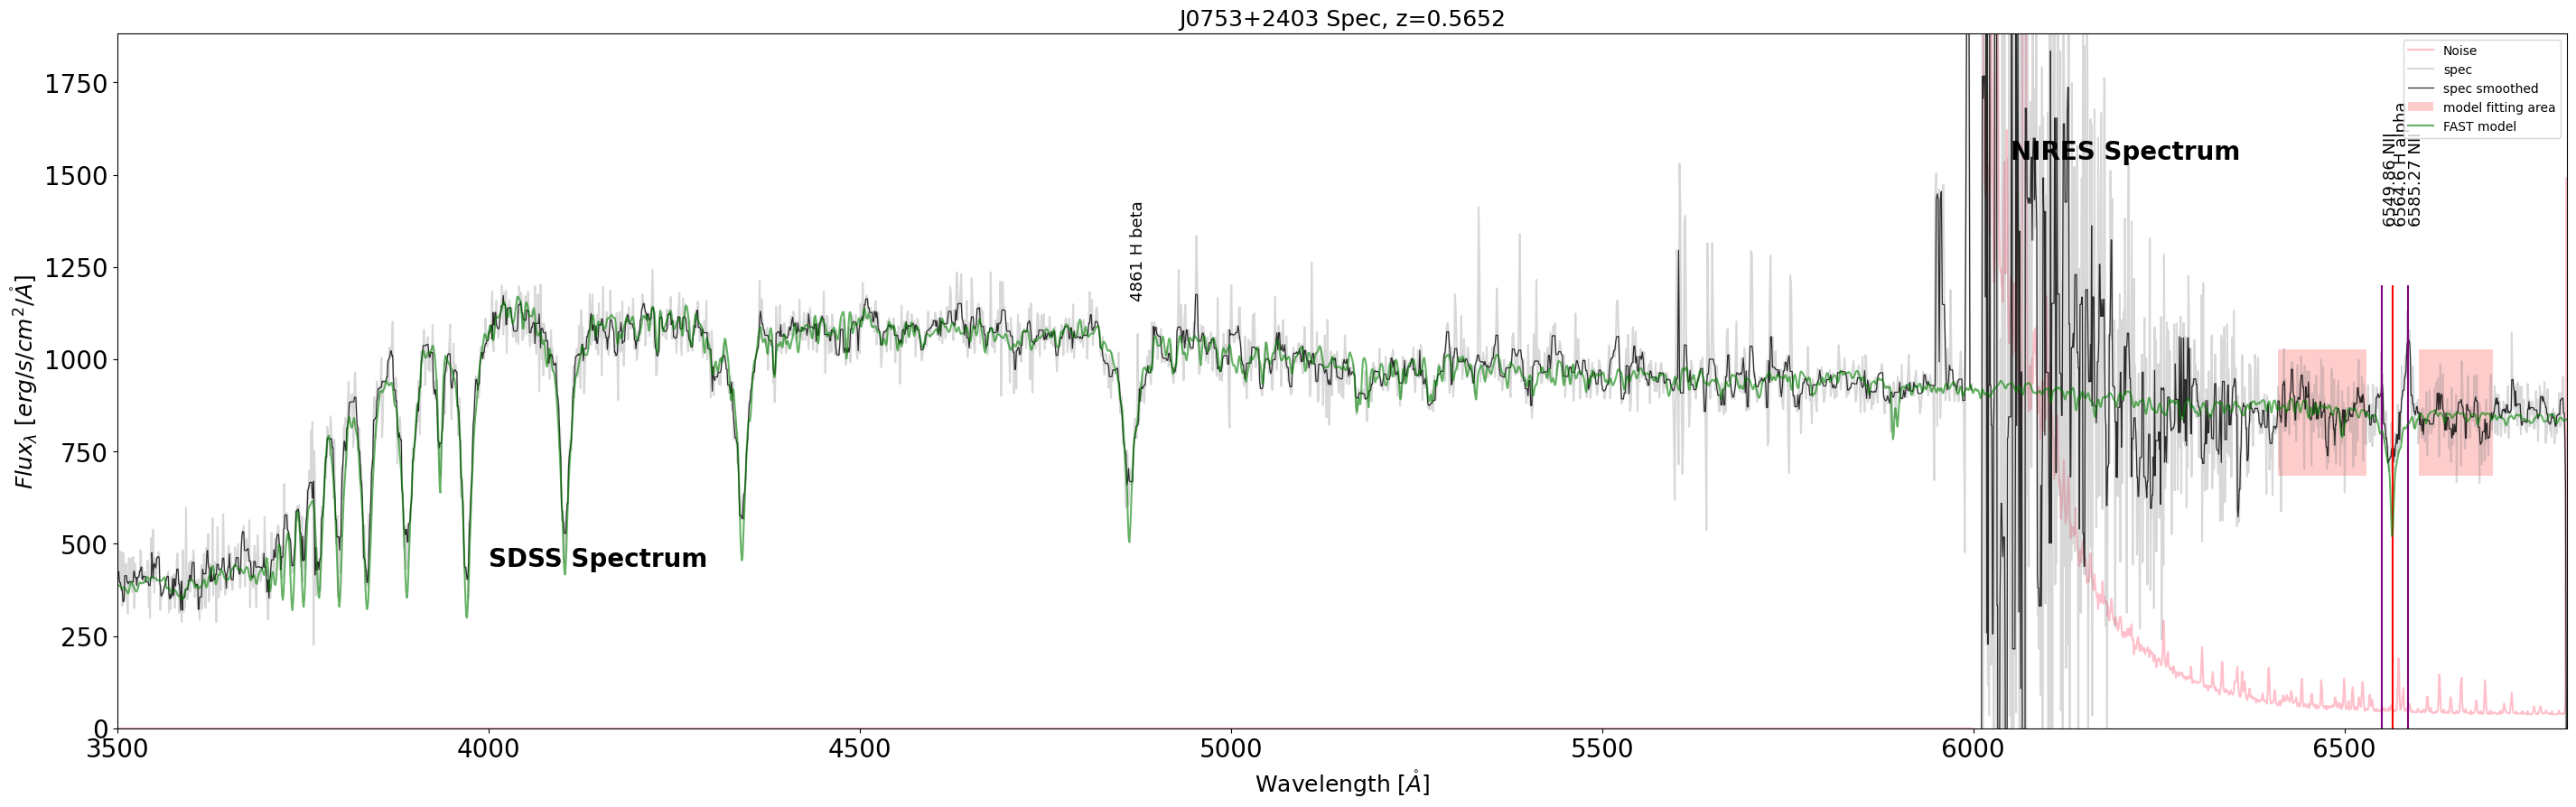

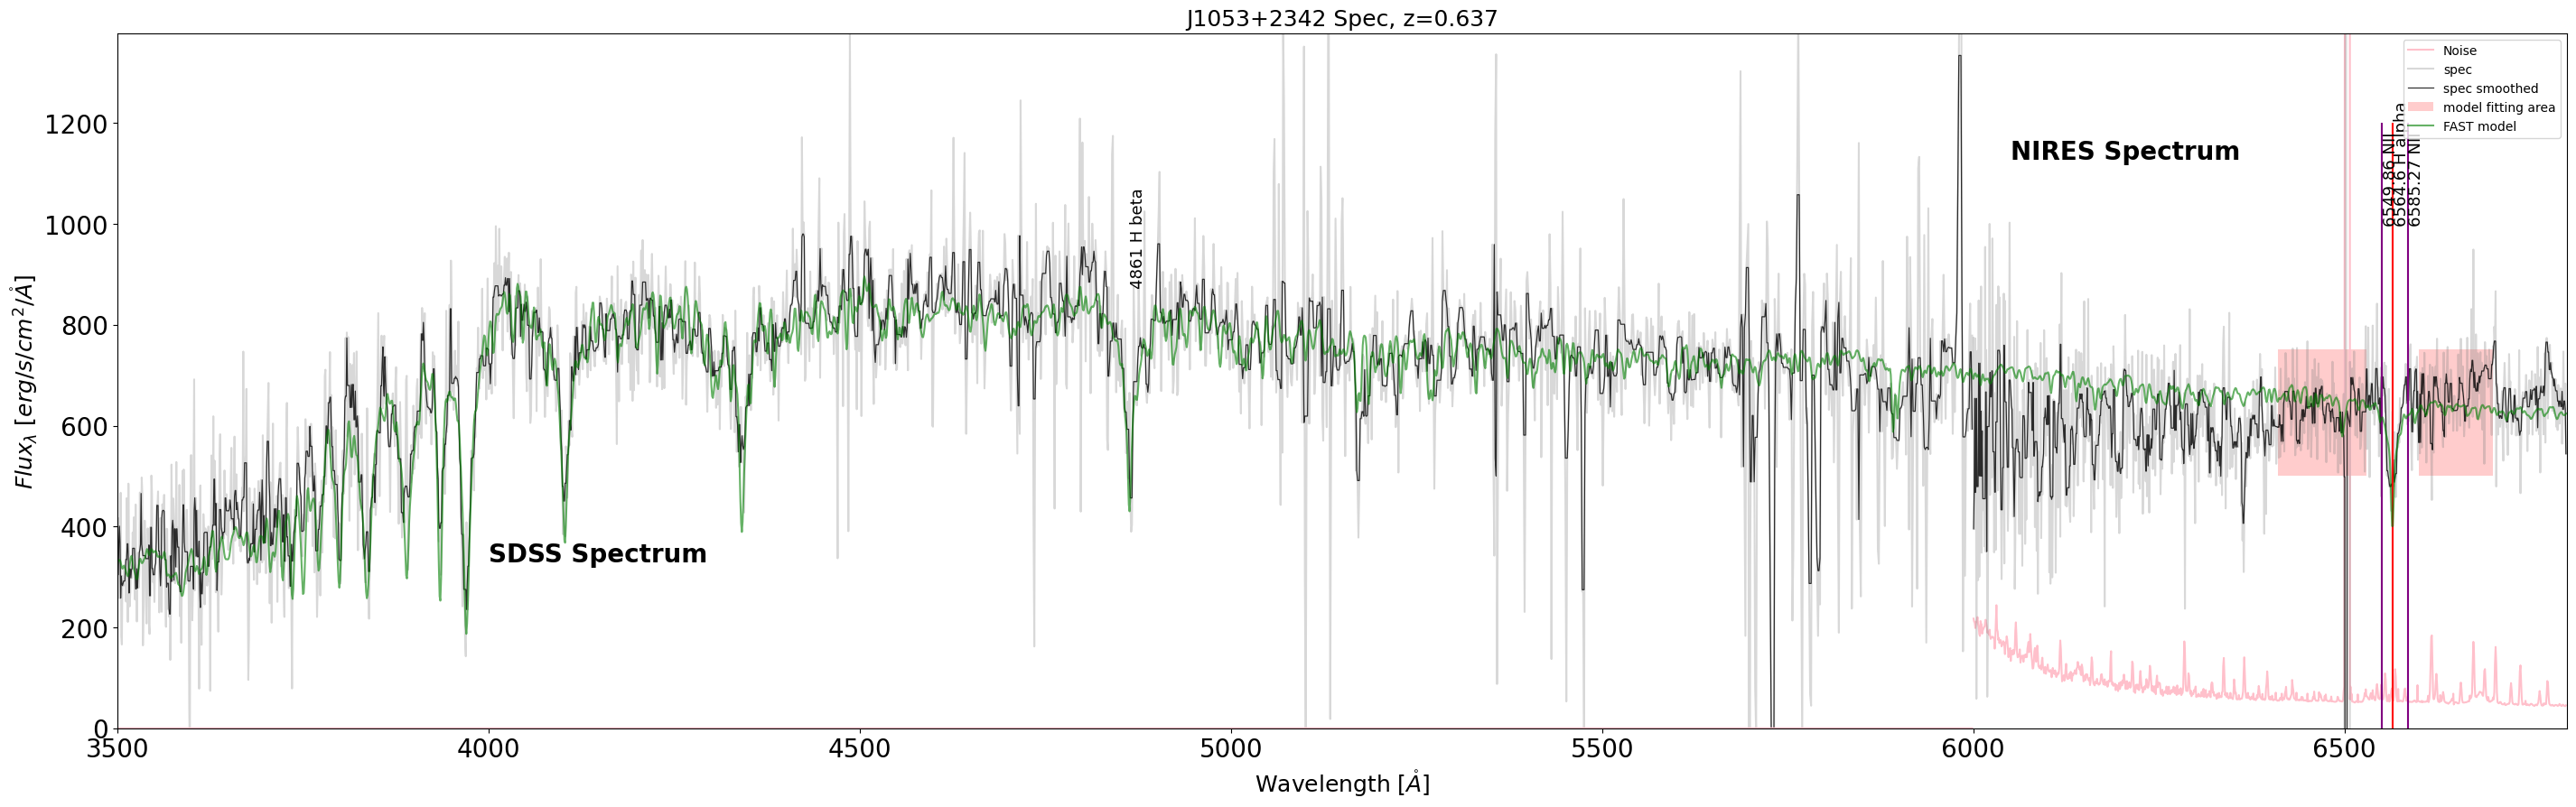

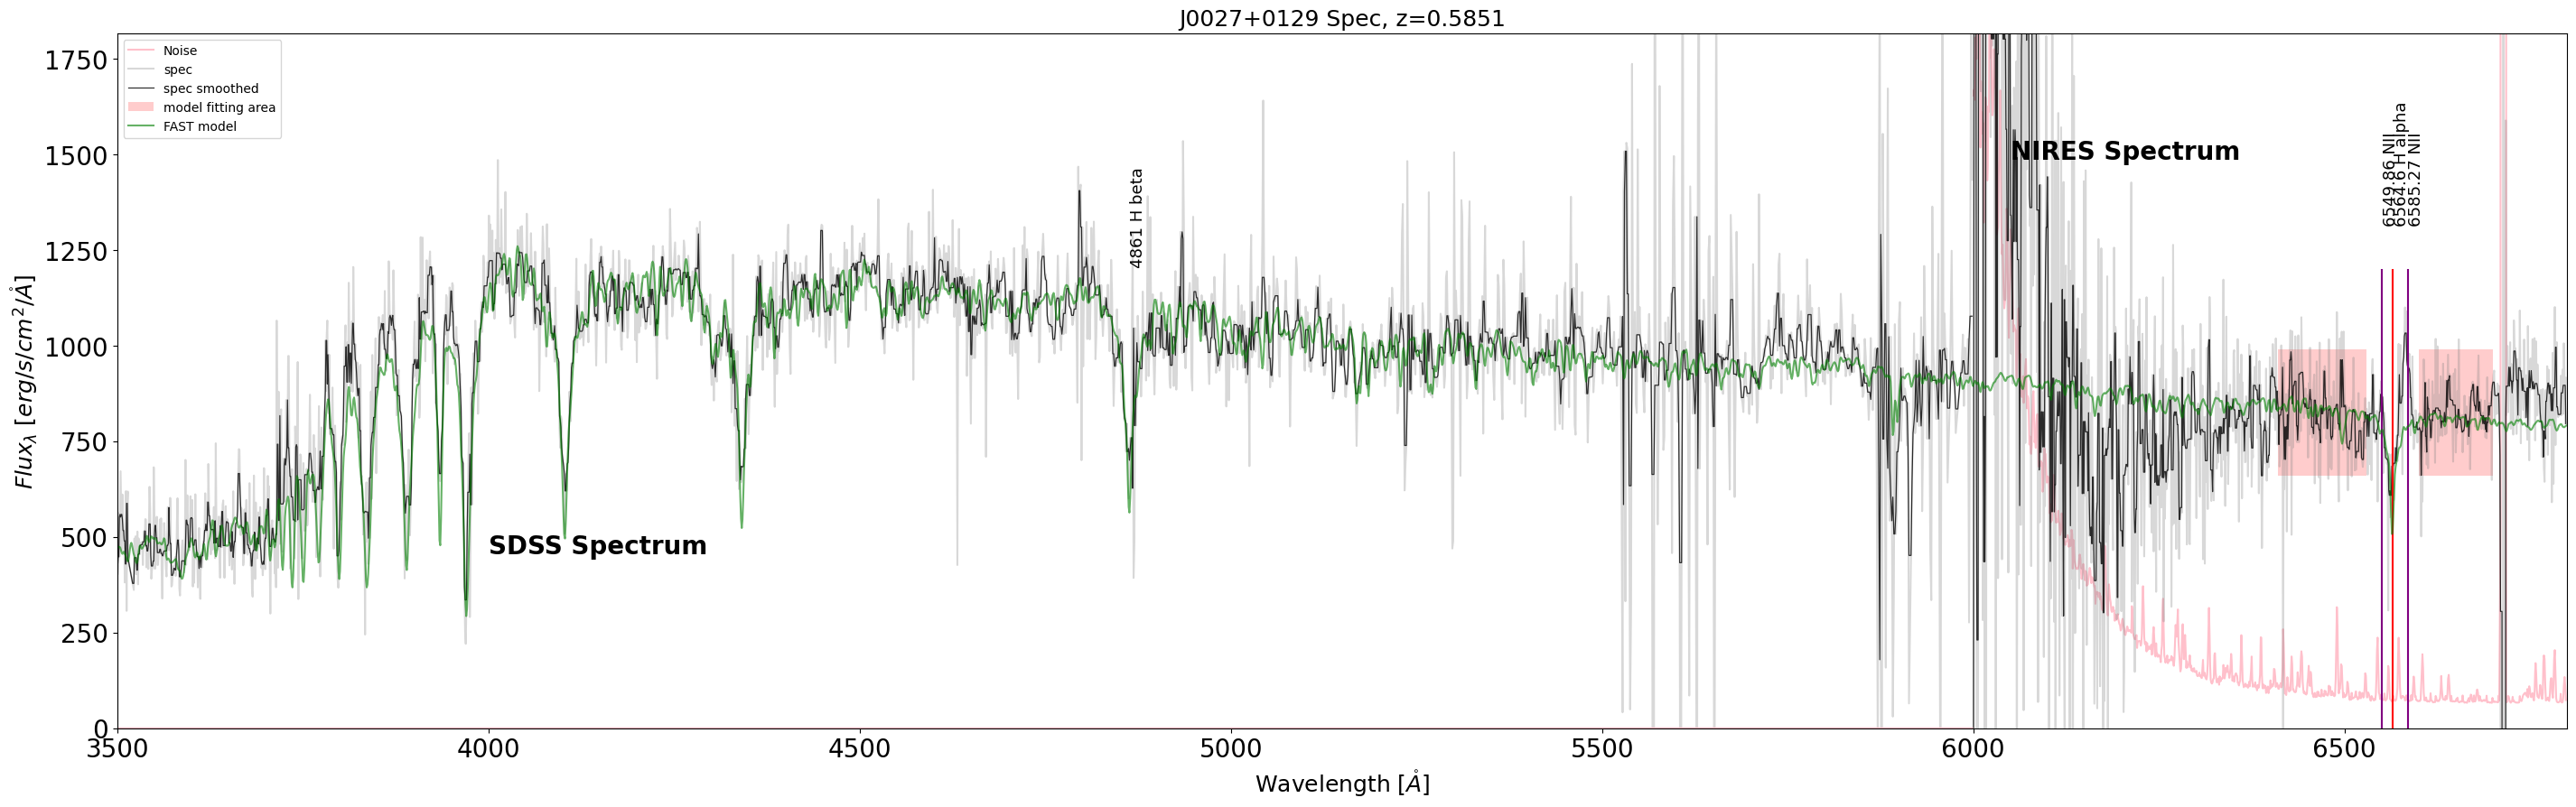

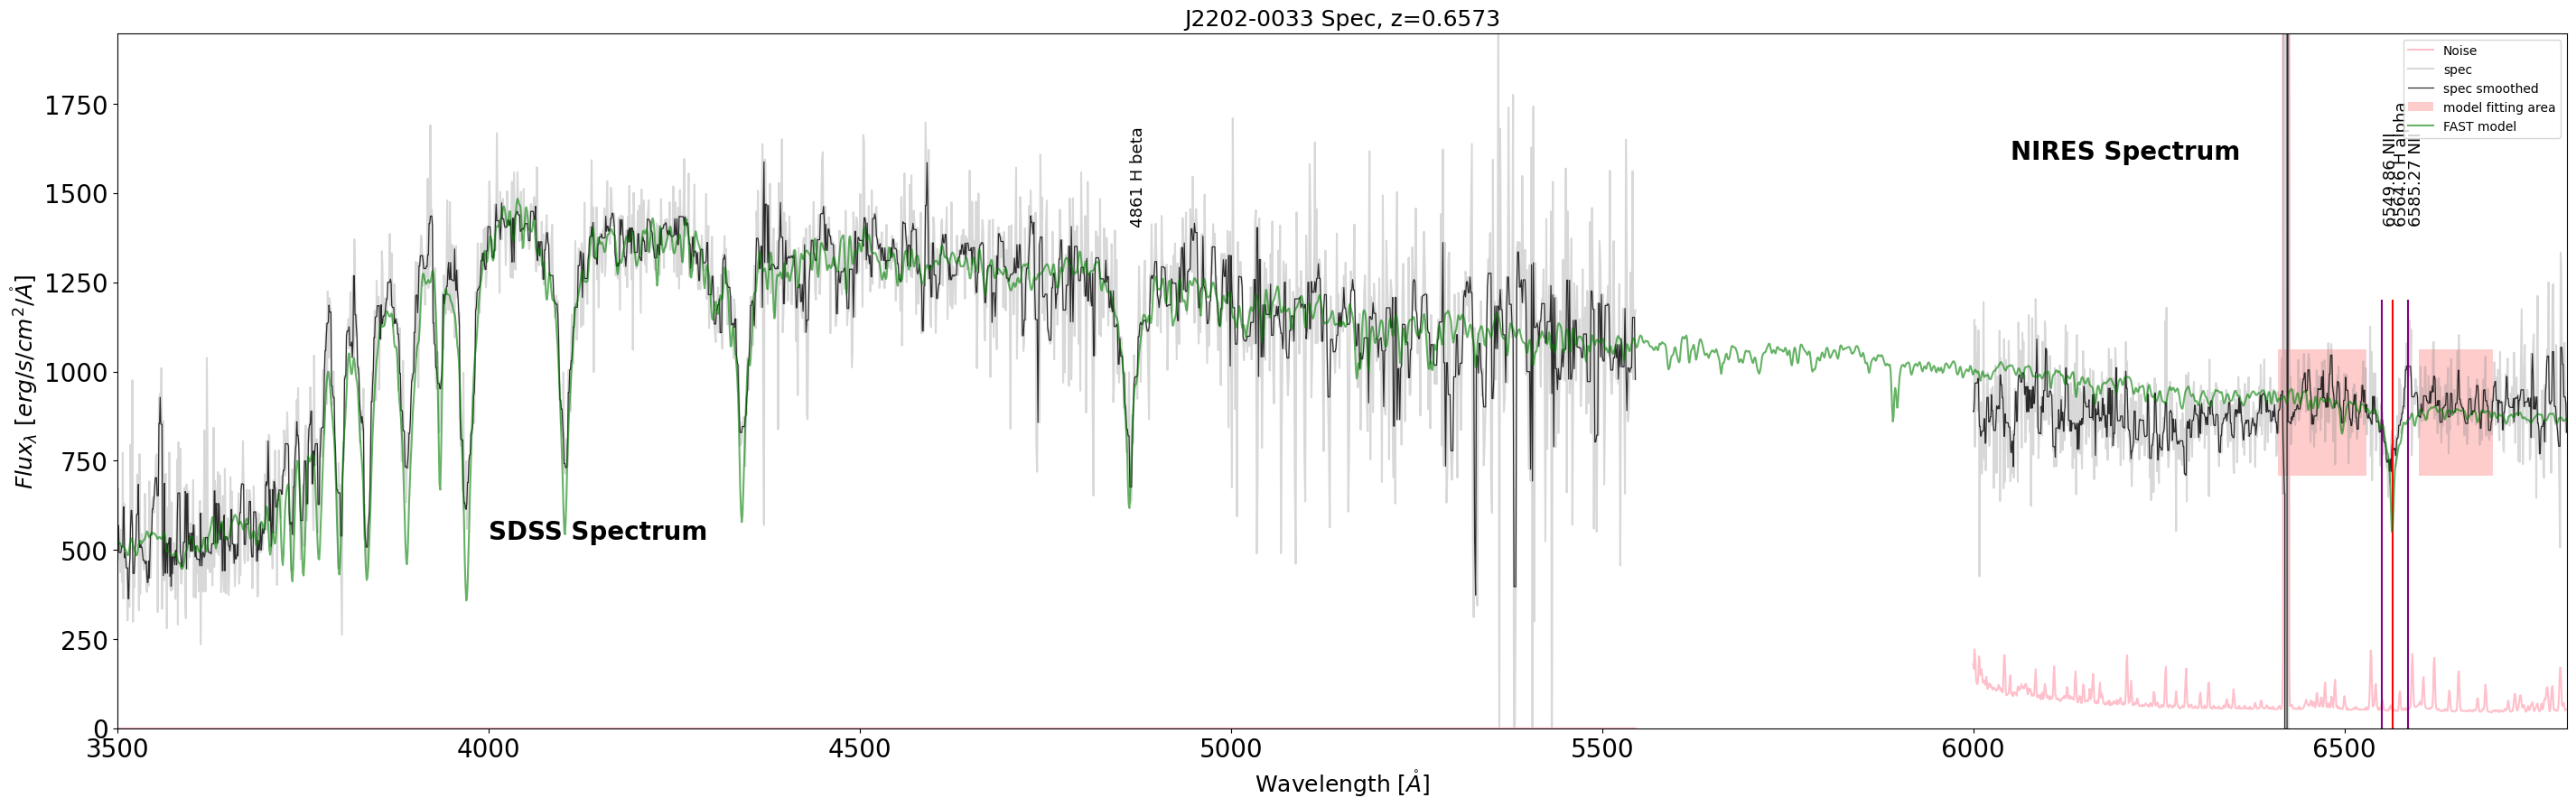

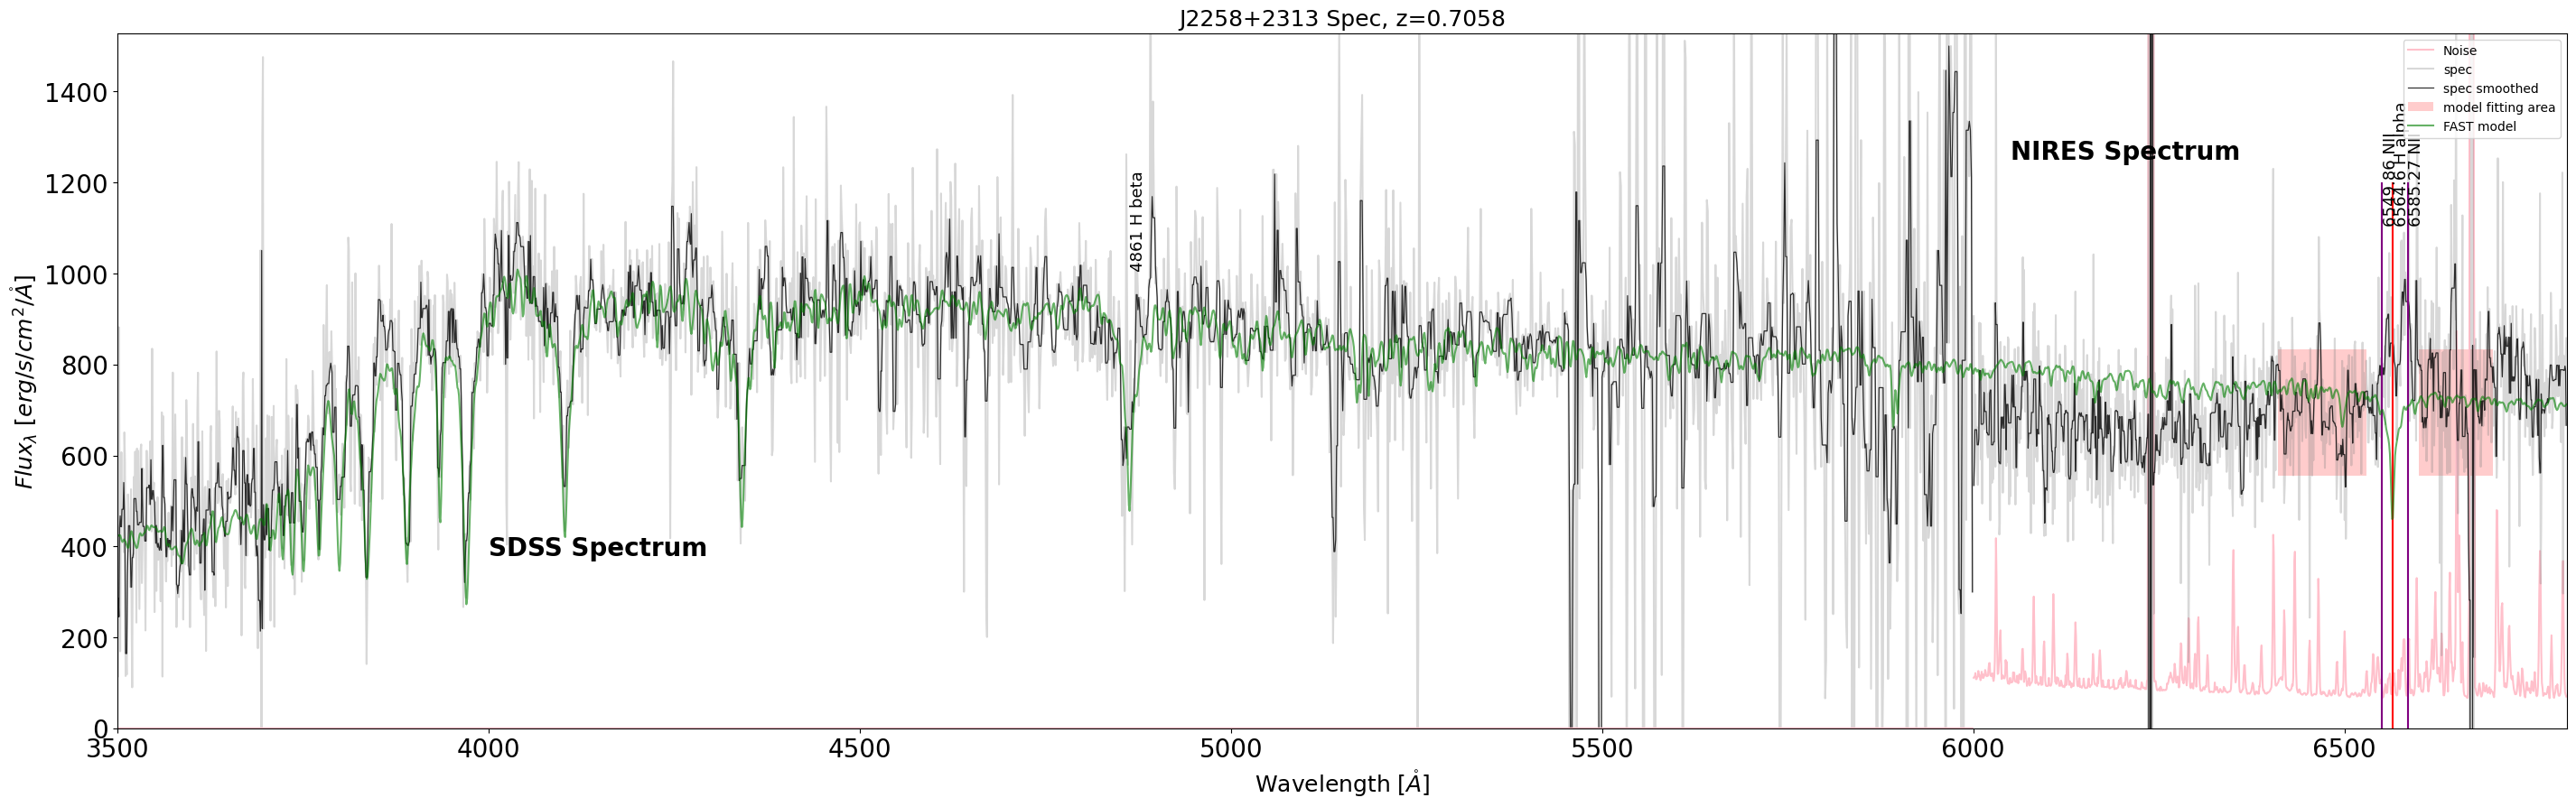

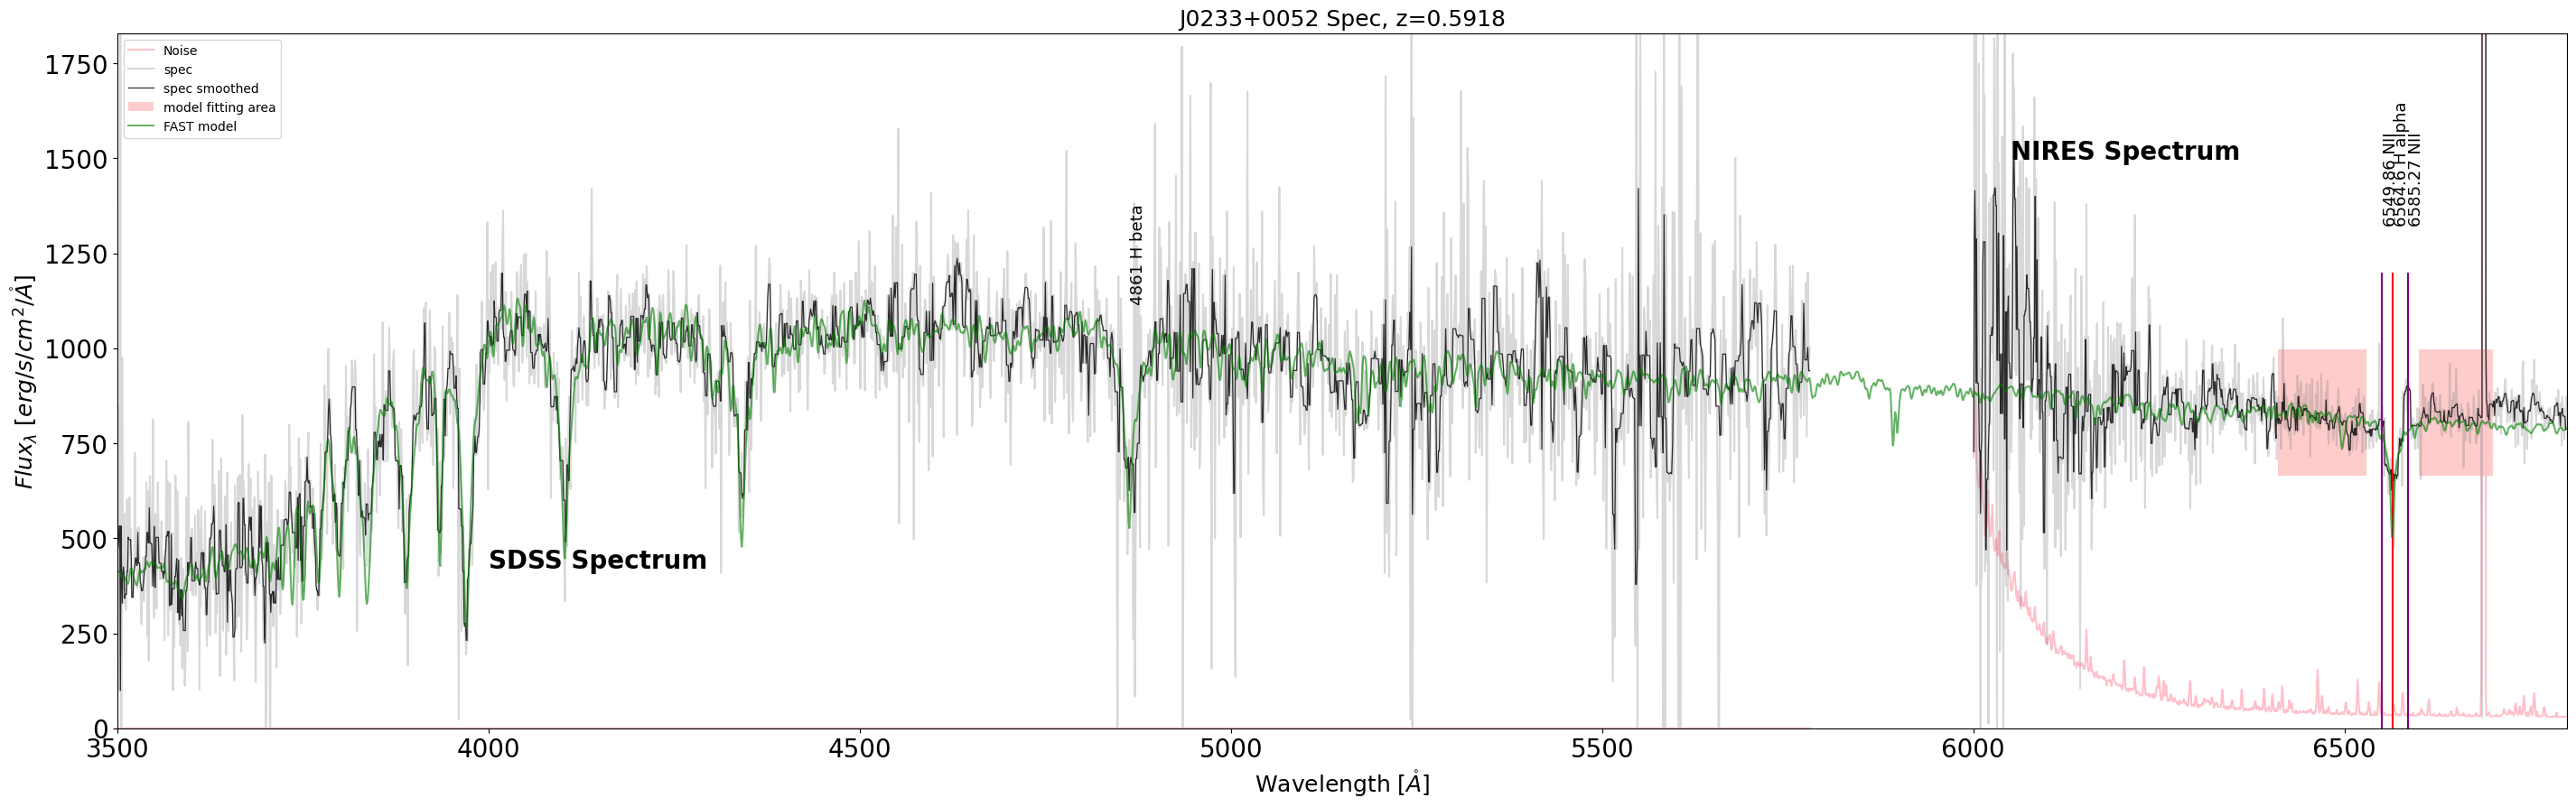

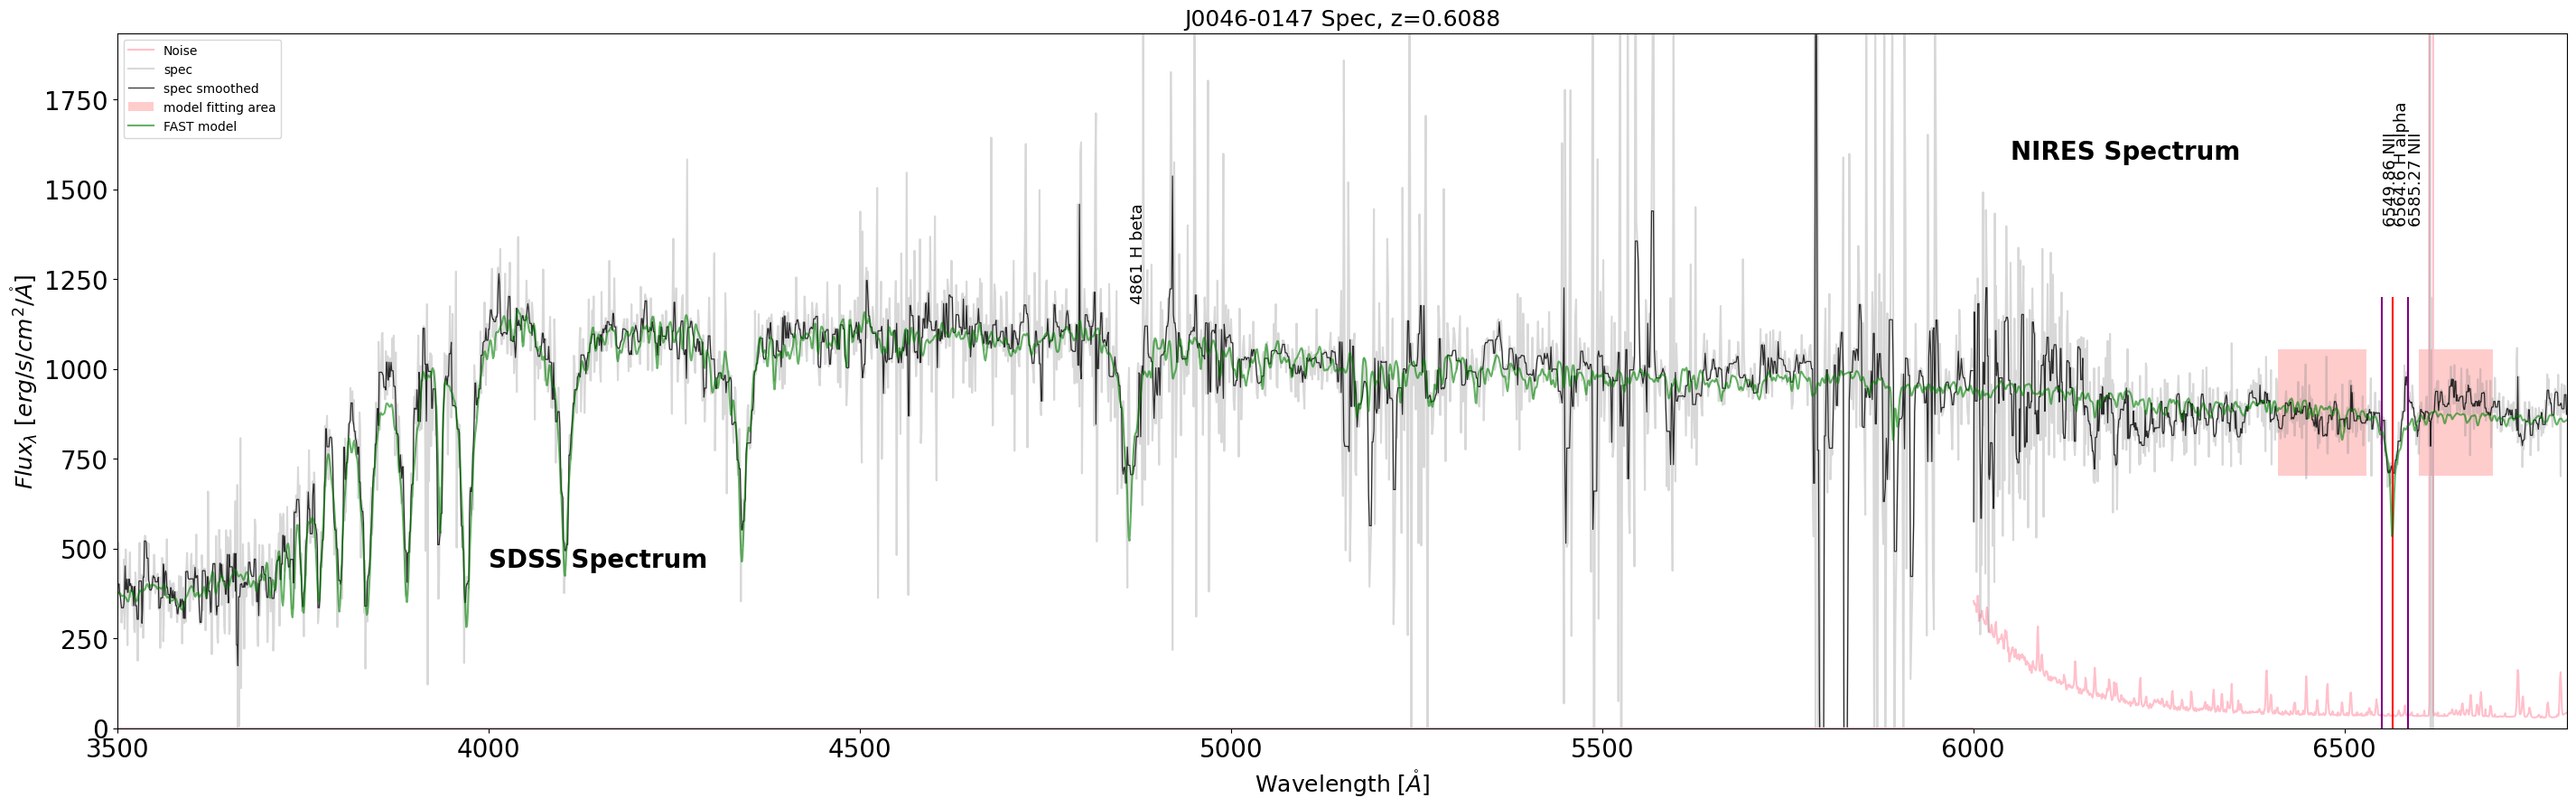

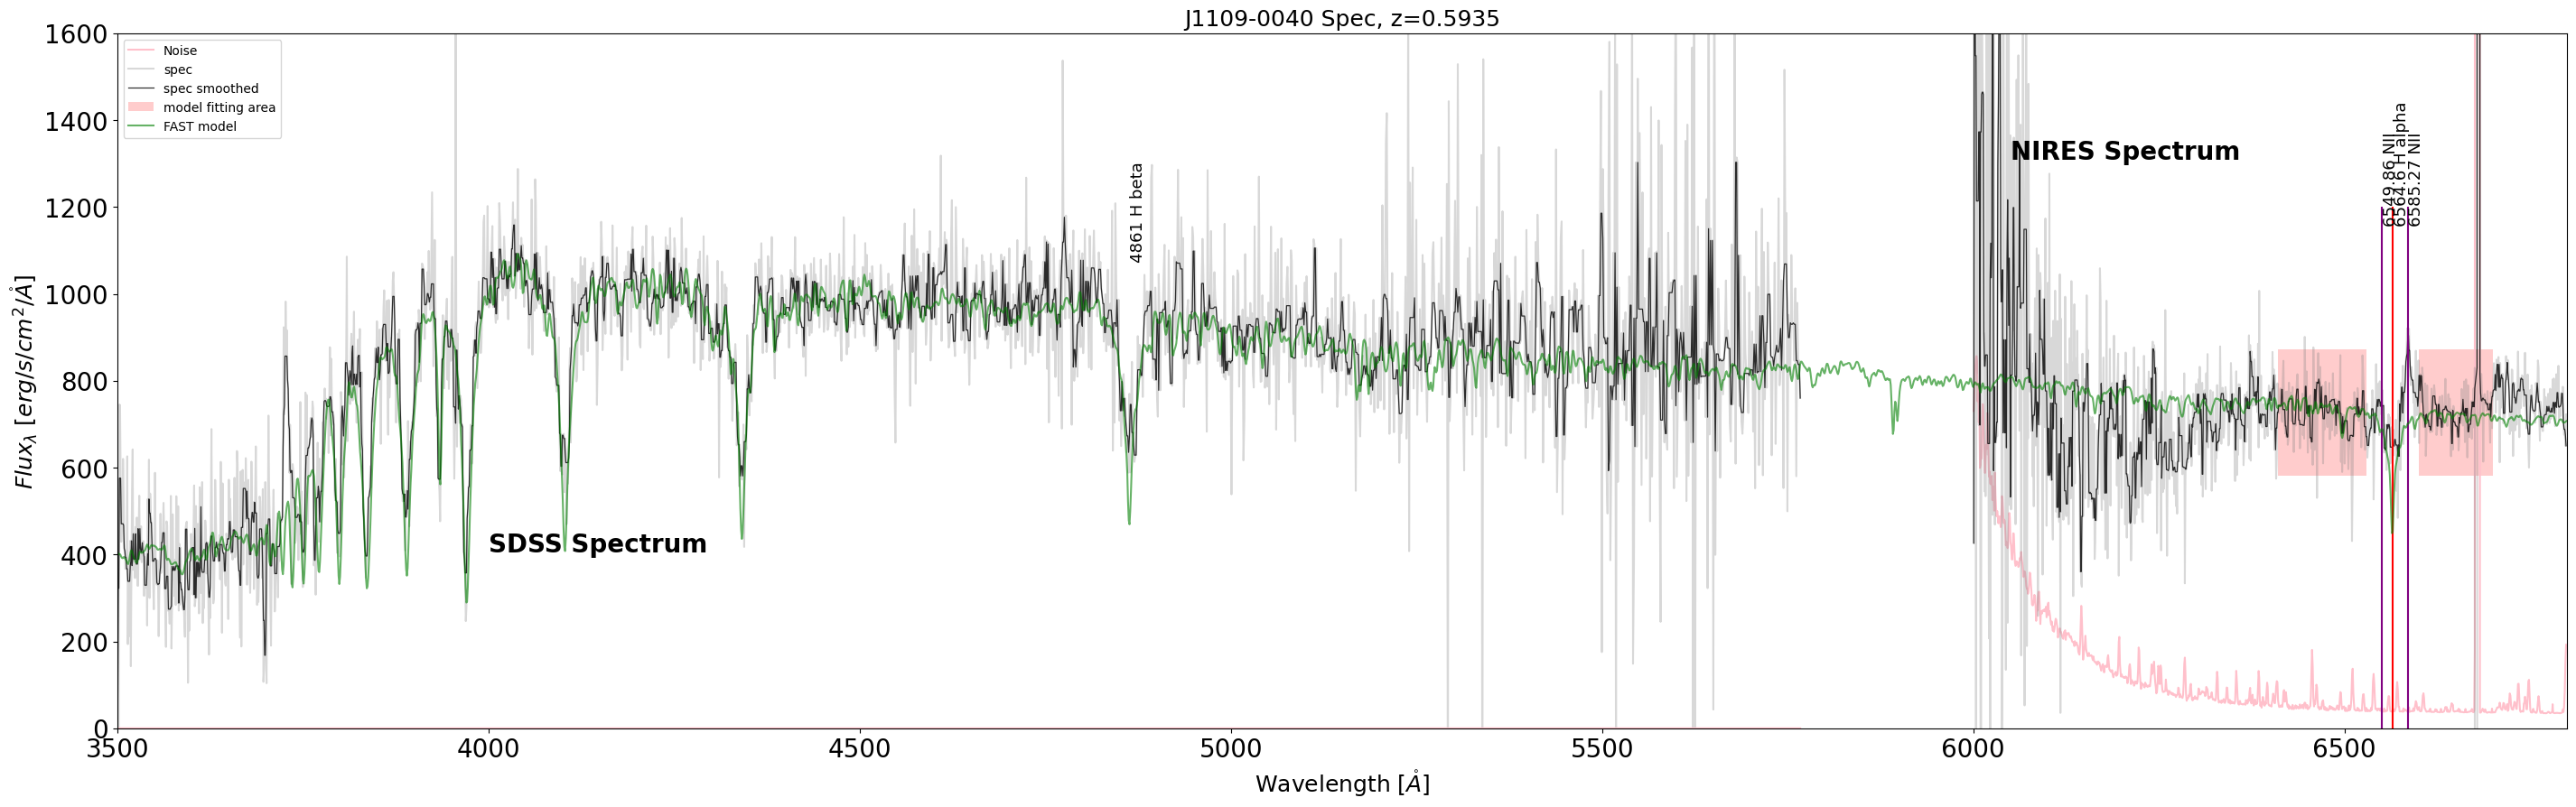

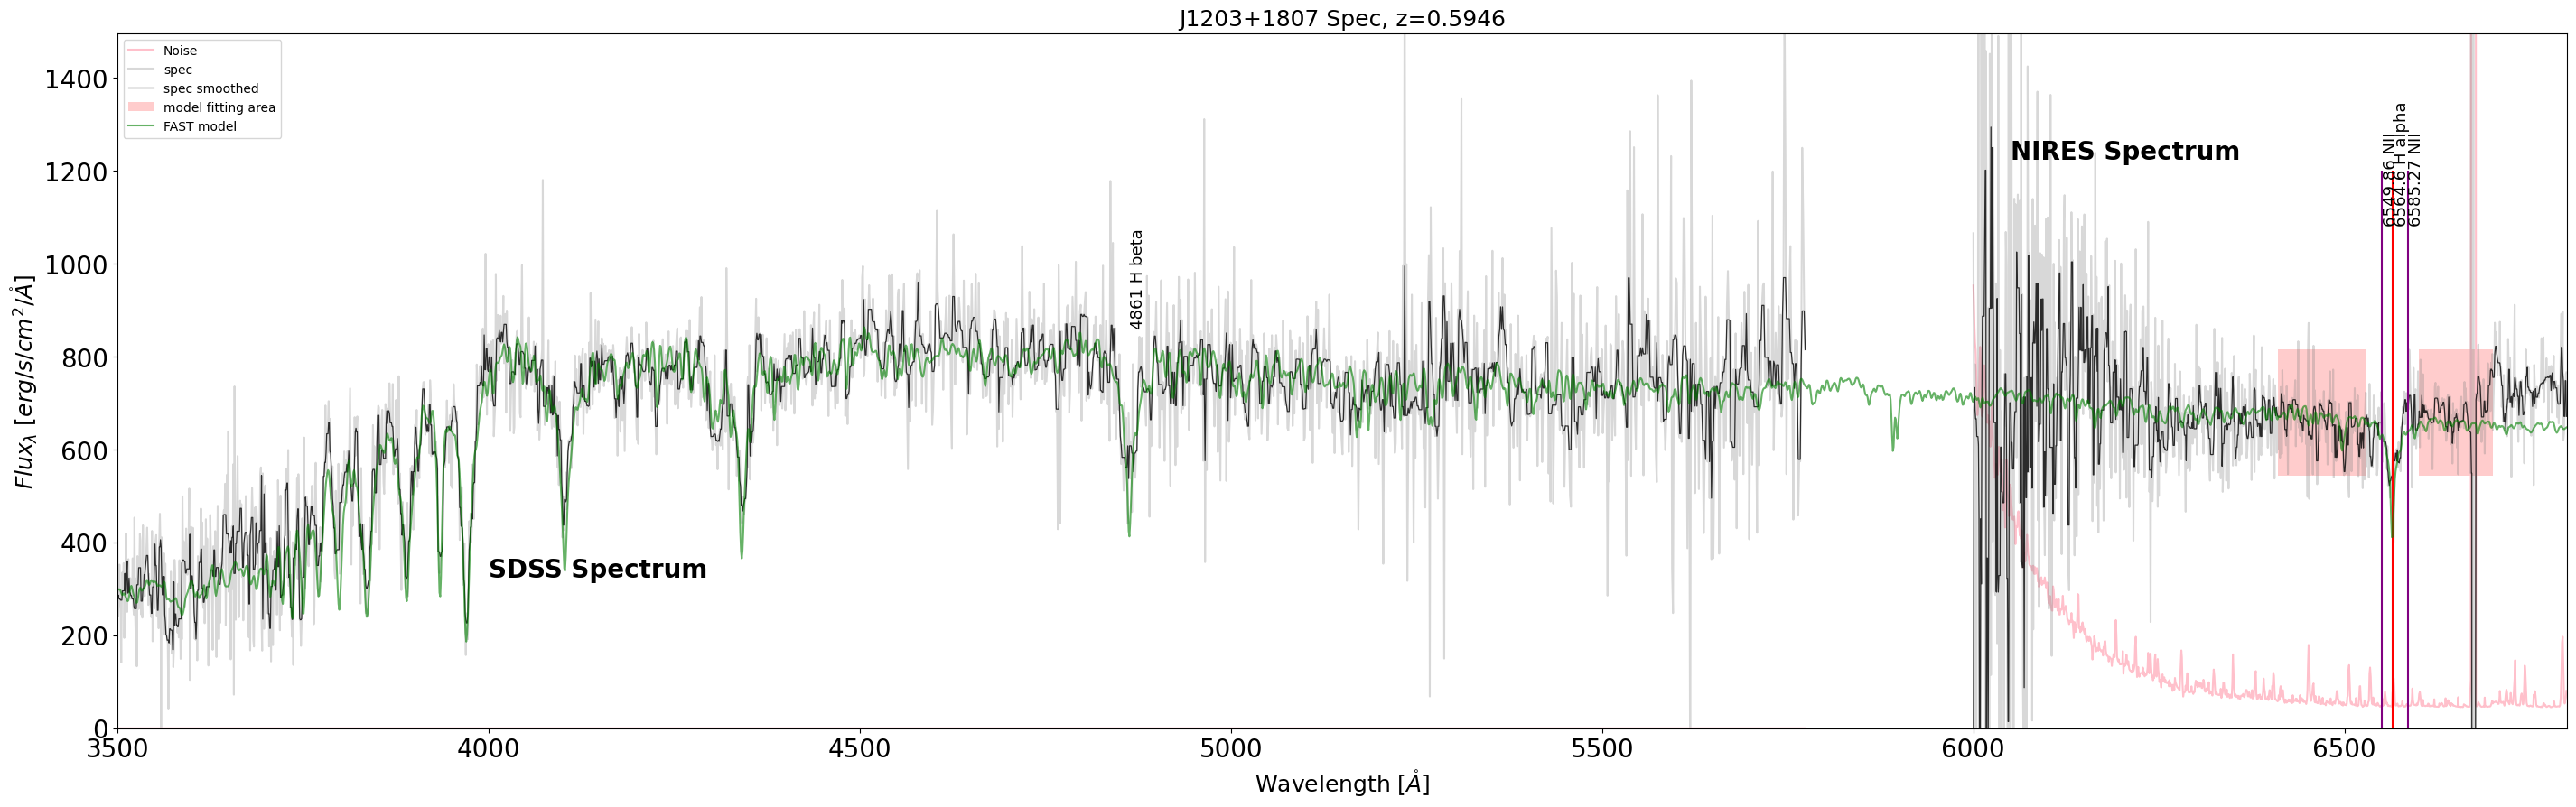

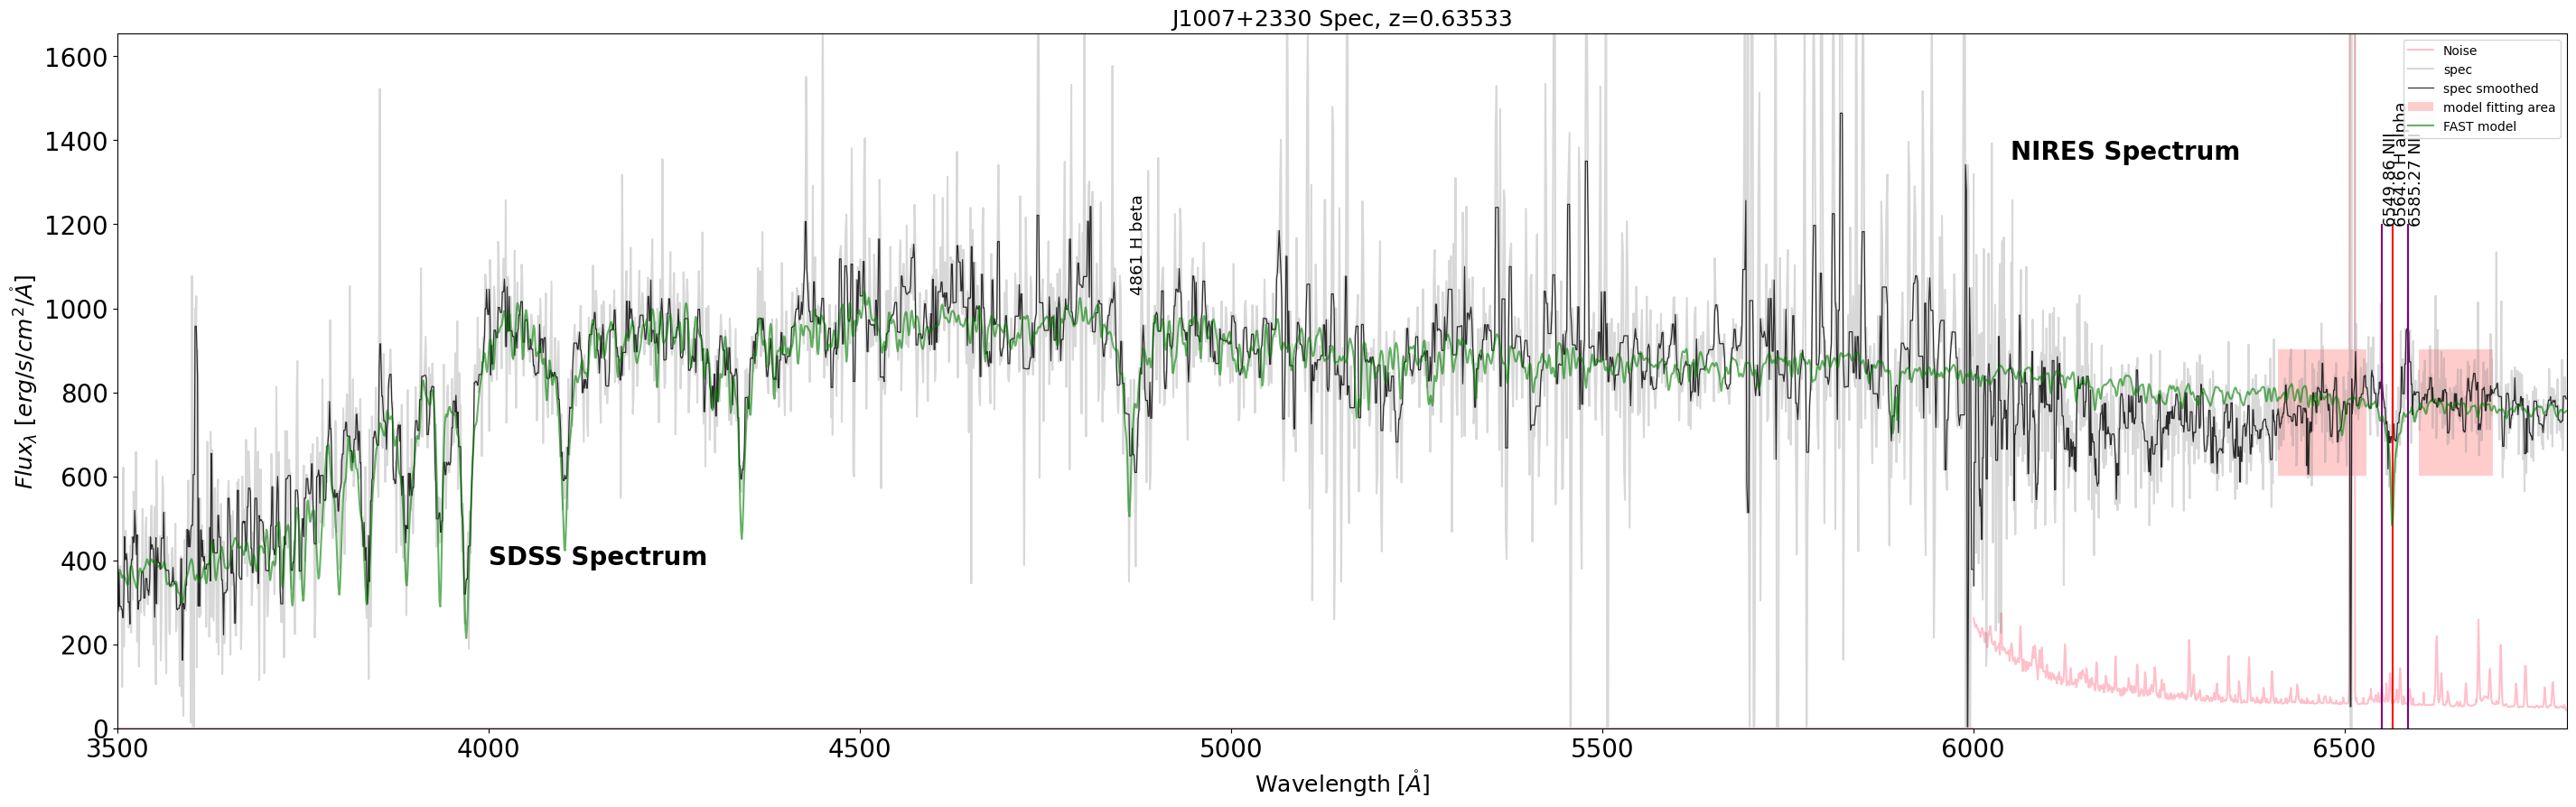

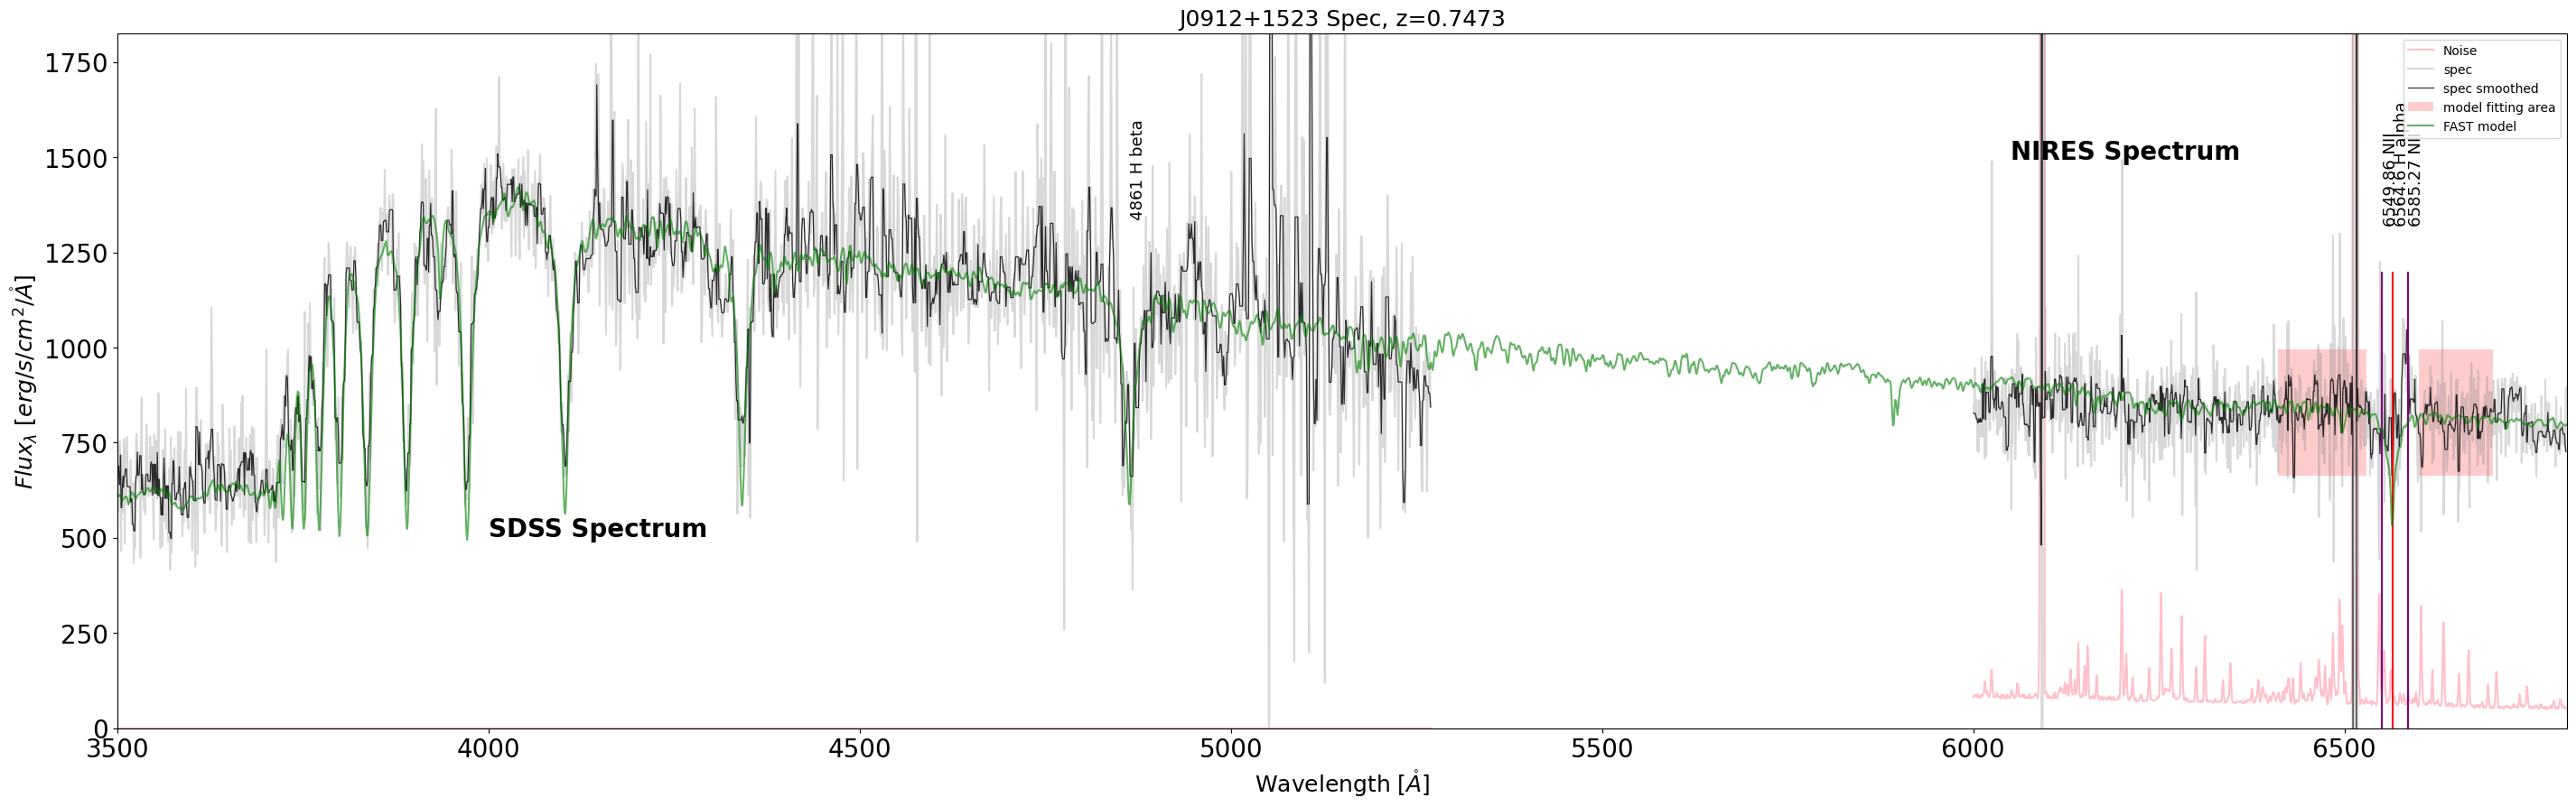

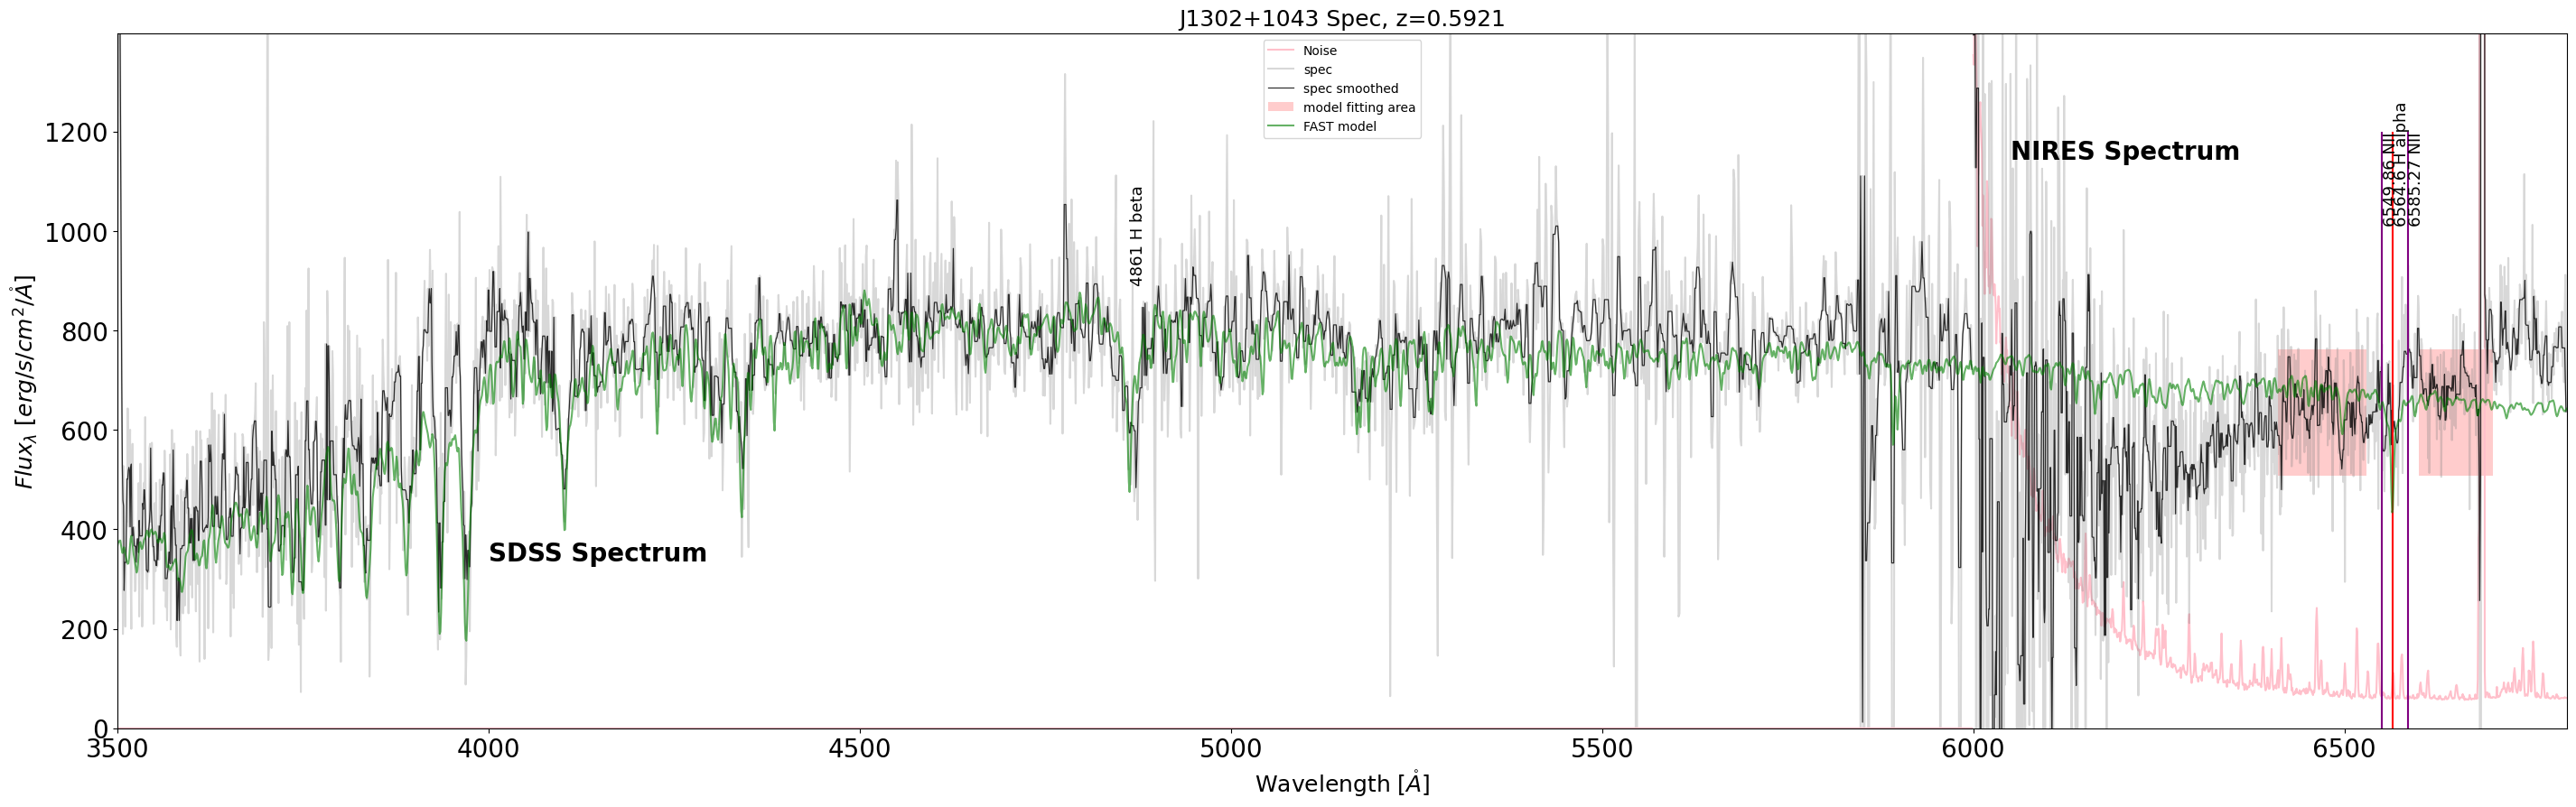

In [217]:
for target in target_names[1:14]:
    plot_spectra_with_models(target,plot_SDSS=True)